# Final Project, DSCI 598
# Chavon Jackson, Paul Desmond, Greg Ballard

### https://maryville.instructure.com/courses/83764/pages/ieee-fraud-detection?module_item_id=7378399

# {GITHUB ENVIRONMENT}
# {Collab Link}

# SUBMITTAL WAS PRIVATE SCORE OF 0.85 and Public Score was .88

# Fraud Detection Data Pipeline

## Introduction to Model and Approach

This notebook focuses on training, evaluating, and analyzing a LightGBM model for a binary classification task, with an emphasis on robust performance optimization and interpretability. The workflow begins with basic data analysis and preprocessing, where checks for missing values, duplicate entries, and column consistency between datasets are performed. Standardization and normalization are also verified to ensure data consistency before modeling.

To optimize the model, the notebook uses Hyperopt for automated hyperparameter tuning, exploring parameters like learning_rate, num_leaves, and max_depth. 

The evaluation process incorporates Stratified K-Fold Cross-Validation, ensuring reliable performance metrics by accounting for class imbalances across multiple data splits. 

The AUC score serves as the primary evaluation metric, with visualizations like AUC distributions and scatter plots helping analyze the relationship between hyperparameters and performance.

Model interpretability is addressed using SHAP values, which identify the most influential features driving the model's predictions. Correlation heatmaps and feature importance plots provide further insights into how hyperparameters and features impact results.

Finally, the notebook demonstrates how to generate predictions using the trained LightGBM model. 

Predictions are made on the test dataset, formatted into a submission-ready file (submission.csv), and saved for evaluation or competition purposes. 

This approach combines optimization, evaluation, and interpretability, producing a high-performing and well-documented LightGBM model.

While working on this script for the IEEE-CIS Fraud Detection Kaggle competition, we ran into a series of challenges, both technical and conceptual, that tested my problem-solving abilities and forced me to rethink parts of my approach.

## Challenges
One of the first issues weI faced was dealing with the size and complexity of the dataset. The data was large, with hundreds of features split across two files, requiring careful merging and preprocessing. This included identifying and handling missing values, reconciling discrepancies between train and test sets, and addressing high-cardinality categorical features. It took significant effort to ensure the data was clean and consistent, especially with certain columns having thousands of unique values, which created memory and runtime constraints.

Another major challenge was feature engineering and selection. With such a diverse set of features, ranging from device types to transaction-specific information, I needed to determine which features were most valuable for the model. Some features seemed promising but added noise, while others required transformations, like encoding or scaling, to be useful. I also had to test feature importance methods like SHAP values to understand which features drove the model's predictions.

When it came to hyperparameter tuning, I initially struggled to strike the right balance between model complexity and generalization. Tuning parameters like learning_rate, num_leaves, and max_depth using Hyperopt was time-consuming, and ensuring the model didn’t overfit required careful use of stratified K-fold cross-validation. At times, the AUC scores would fluctuate unexpectedly across folds, which made me question whether my validation strategy was robust enough.

Performance optimization was another hurdle. While LightGBM is efficient, generating predictions on large datasets required monitoring computational resources and execution time. I also had to ensure that saving and loading the model worked seamlessly, as errors in file paths or iterations sometimes caused the model to behave unpredictably during prediction.

One of the recurring challenges I faced during this project was working with Google Colab and dealing with runtime limitations. Given the large-scale dataset and the computational intensity of training LightGBM models with hyperparameter tuning, I frequently ran into Colab’s runtime constraints. Training models, especially with multiple iterations during cross-validation and Hyperopt optimization, pushed the limits of the available CPU and RAM. Additionally, the free tier’s runtime cap of 12 hours (or less for inactive sessions) meant I had to restart sessions and lose progress if I wasn’t careful about saving intermediate results, like models or checkpoints. At times, I experienced unexpected disconnects or slowdowns, particularly when processing large datasets or generating predictions. In the end, moved 

### Setup Phase





In [1]:
"""pip install lightgbm
pip install imbalanced-learn
pip install shap
pip install joblib
pip install gdown
pip install category_encoders
"""

'pip install lightgbm\npip install imbalanced-learn\npip install shap\npip install joblib\npip install gdown\npip install category_encoders\n'

In [2]:
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

# Basic Libraries
import numpy as np  # Numerical computations
import pandas as pd  # Data processing, CSV file I/O
import os  # Operating system utilities
import gc  # Garbage collection
import random  # Random number generation

# Visualization Libraries
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Statistical data visualization
import graphviz  # Graph visualization
from IPython.display import display  # Jupyter Notebook display utilities
#%matplotlib inline  # Inline plotting for Jupyter Notebooks

# Statistical Libraries
from scipy import stats  # Statistical functions
from scipy.stats import ttest_ind  # T-test for independent samples
from statsmodels.stats.outliers_influence import variance_inflation_factor  # VIF calculation

# Machine Learning Libraries
from sklearn.ensemble import RandomForestClassifier, IsolationForest  # Ensemble methods
from sklearn.decomposition import PCA  # Principal Component Analysis
from sklearn.impute import SimpleImputer, IterativeImputer  # Handling missing values
from sklearn.experimental import enable_iterative_imputer  # Enable experimental features
from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold, 
    cross_val_score
)  # Model validation techniques
from sklearn.metrics import (
    roc_auc_score, 
    classification_report, 
    accuracy_score
)  # Model evaluation metrics
from sklearn.preprocessing import (
    StandardScaler, 
    LabelEncoder, 
    PowerTransformer
)  # Data preprocessing
from sklearn.feature_selection import mutual_info_classif  # Feature selection
from lightgbm import LGBMClassifier  # Gradient boosting

# Encoding Libraries
from category_encoders import TargetEncoder  # Target-dependent encoding

# Performance and Utility Libraries
from tqdm import tqdm  # Progress bar for loops
from tqdm.notebook import tqdm as tqdm_notebook  # Notebook-friendly tqdm
from numba import jit  # JIT compiler for performance
from numpy.random import default_rng  # Random number generation
import joblib  # Serialization and persistence

# High-Performance DataFrames
import polars as pl  # Alternative to pandas for high-performance data manipulation

# Other Utilities
import datetime  # Working with dates and times
import scipy as sp  # Scientific computations
import gdown  # Download files from Google Drive

# Modelign v1
import os
import numpy as np
import pandas as pd
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL, space_eval
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import joblib
import logging

#Modeling v2
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import os
import joblib
import shap

# Pandas Display Options
pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000
pd.options.display.max_colwidth = 1000


# 2. Data Loading and Initial Checks



In [ ]:

# Load identity dataset
df_test_id = pd.read_csv("C:\\Users\\gpbal\\OneDrive\\Desktop\\test_identity.csv", low_memory=False)
print(f"Identity dataset loaded successfully with shape: {df_test_id.shape}")

# Load transaction dataset
df_test_trans = pd.read_csv("C:\\Users\\gpbal\\OneDrive\\Desktop\\test_transaction.csv", low_memory=False)
print(f"Transaction dataset loaded successfully with shape: {df_test_trans.shape}")

df_train_id = pd.read_csv("C:\\Users\\gpbal\\OneDrive\\Desktop\\train_identity.csv", low_memory=False)
print(f"Identity dataset loaded successfully with shape: {df_test_id.shape}")

# Load transaction dataset
df_train_trans = pd.read_csv("C:\\Users\\gpbal\\OneDrive\\Desktop\\train_transaction.csv", low_memory=False)
print(f"Transaction dataset loaded successfully with shape: {df_test_trans.shape}")


# Verify that 'TransactionID' exists in both datasets
assert 'TransactionID' in df_test_trans.columns, "'TransactionID' not found in transaction dataset."
assert 'TransactionID' in df_test_id.columns, "'TransactionID' not found in identity dataset."

train = df_train_trans.merge(df_train_id, how='left', on='TransactionID')
test = df_test_trans.merge(df_test_id, how='left', on='TransactionID')
        
print(f'train.shape : {train.shape}, test.shape : {test.shape}')

Identity dataset loaded successfully with shape: (141907, 41)
Transaction dataset loaded successfully with shape: (506691, 393)
Identity dataset loaded successfully with shape: (141907, 41)
Transaction dataset loaded successfully with shape: (506691, 393)
train.shape : (590540, 434), test.shape : (506691, 433)


In [4]:
# Display basic information about the dataset
print("Dataset Information:")
train.info()

# Display descriptive statistics for numerical columns
print("\nDataset Description:")
print(train.describe())

# Check for missing values
print("\nMissing Values Count:")
print(train.isnull().sum())

# Check the number of unique values in each column
print("\nUnique Values per Column:")
print(train.nunique())

# Check for duplicate entries
duplicates = train.duplicated().sum()
print(f"\nNumber of Duplicate Rows: {duplicates}")

# Display the first few rows to explore the dataset
print("\nFirst Few Rows of the Dataset:")
train.head()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB

Dataset Description:
       TransactionID        isFraud  TransactionDT  TransactionAmt  \
count   5.905400e+05  590540.000000   5.905400e+05   590540.000000   
mean    3.282270e+06       0.034990   7.372311e+06      135.027176   
std     1.704744e+05       0.183755   4.617224e+06      239.162522   
min     2.987000e+06       0.000000   8.640000e+04        0.251000   
25%     3.134635e+06       0.000000   3.027058e+06       43.321000   
50%     3.282270e+06       0.000000   7.306528e+06       68.769000   
75%     3.429904e+06       0.000000   1.124662e+07      125.000000   
max     3.577539e+06       1.000000   1.581113e+07    31937.391000   

               card1          card2          card3          card5  \
count  590540.000000  581607.000000  588975.000000  586281.00000

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

# Shape

In [5]:
print(train.shape)

(590540, 434)


In [6]:
print("Unique values in 'isFraud' before processing:", train['isFraud'].unique())


Unique values in 'isFraud' before processing: [0 1]


# 3. Initial Preprocessing

Below section of script is a data preprocessing pipeline designed to prepare a dataset for machine learning, specifically targeting fraud detection. 

It begins by analyzing relationships between paired columns in the training and testing datasets using the count_uniques function. This function calculates the number of unique values in one column for each unique value in another, enabling the identification of consistent or missing data patterns across categories.

To address missing values (NaNs), the fill_card_nans function fills them conditionally. If a category has only one unique corresponding value, it replaces the NaN with that value, preserving the integrity of categorical relationships. The nans_distribution function further evaluates the distribution of missing values across categories, providing insights into where data gaps are concentrated.

The script also emphasizes memory optimization. The sd function reduces memory usage by safely downcasting numeric columns to smaller data types, ensuring minimal precision loss within defined thresholds. This functionality is applied across the dataset using reduce_mem_usage_sd, significantly reducing the memory footprint and enhancing processing efficiency.

Feature engineering is a critical part of the pipeline. Temporal features such as DaysFromStart and D1-DaysFromStart are calculated to capture transaction timing patterns, potentially enhancing the model's predictive power. Additionally, a unique identifier (UID) is created by combining several categorical columns. This UID is used for aggregating data and extracting summary statistics like fraud counts and transaction frequencies.

Once feature transformations are complete, the dataset undergoes final adjustments. Engineered columns that are no longer needed are dropped, and the processed datasets are saved in both CSV and pickle formats. The use of pickle files allows for efficient reloading during future analysis. To ensure consistency, training and testing datasets are temporarily merged for uniform processing before being split back into separate datasets.

Overall, this script provides a robust and efficient preprocessing framework. It enhances data quality, optimizes memory usage, and creates meaningful features, all of which are critical for building a strong foundation for a machine learning model in fraud detection.

## Function library for preprocessing test and train dataset

The functions below are used to handle paired relationships, manage missing values, analyze NaN distributions, and optimize memory usage in datasets. 

The count_uniques function calculates the number of unique values in a paired column relationship for both train and test datasets, outputting two Pandas Series containing these unique counts grouped by the first column in the pair. Building on this, the fill_card_nans function fills missing values (NaN) in the second column of the pair by identifying groups in the first column where the second column has exactly one unique value, then imputing the missing values with the most common value within those groups. This ensures cleaner data for modeling.

To further analyze missing data, the nans_distribution function computes the distribution of NaN values in a paired column relationship, outputting two Series that summarize the number of missing values for each unique group in the first column for both train and test datasets. For memory optimization, the sd (safe downcast) function reduces the memory usage of numeric columns by downcasting their data types while preserving data integrity within specified precision loss thresholds. 

Finally, the reduce_mem_usage_sd function applies the sd function across all numeric columns in a DataFrame and optionally converts object-type columns to categorical, significantly reducing memory usage. This function also provides detailed warnings and insights about potential loss of NaN or unique values, helping ensure data consistency while optimizing performance. Together, these functions provide a robust toolkit for handling missing values, analyzing data distributions, and enhancing efficiency in large datasets.

In [7]:
test.columns = [col.replace('-', '_') for col in test.columns] #Column issue with test data

In [8]:
def count_uniques(train, test, pair):
    unique_train = []
    unique_test = []

    for value in train[pair[0]].unique():
        unique_train.append(train[pair[1]][train[pair[0]] == value].value_counts().shape[0])

    for value in test[pair[0]].unique():
        unique_test.append(test[pair[1]][test[pair[0]] == value].value_counts().shape[0])

    pair_values_train = pd.Series(data=unique_train, index=train[pair[0]].unique())
    pair_values_test = pd.Series(data=unique_test, index=test[pair[0]].unique())
    
    return pair_values_train, pair_values_test

def fill_card_nans(train, test, pair_values_train, pair_values_test, pair):
    print(f'In train{[pair[1]]} there are {train[pair[1]].isna().sum()} NaNs' )
    print(f'In test{[pair[1]]} there are {test[pair[1]].isna().sum()} NaNs' )

    print('Filling train...')
    
    for value in pair_values_train[pair_values_train == 1].index:
        train[pair[1]][train[pair[0]] == value] = train[pair[1]][train[pair[0]] == value].value_counts().index[0]
        
    print('Filling test...')

    for value in pair_values_test[pair_values_test == 1].index:
        test[pair[1]][test[pair[0]] == value] = test[pair[1]][test[pair[0]] == value].value_counts().index[0]
        
    print(f'In train{[pair[1]]} there are {train[pair[1]].isna().sum()} NaNs' )
    print(f'In test{[pair[1]]} there are {test[pair[1]].isna().sum()} NaNs' )
    
    return train, test

def nans_distribution(train, test, unique_train, unique_test, pair):
    train_nans_per_category = []
    test_nans_per_category = []

    for value in unique_train.unique():
        train_nans_per_category.append(train[train[pair[0]].isin(list(unique_train[unique_train == value].index))][pair[1]].isna().sum())

    for value in unique_test.unique():
        test_nans_per_category.append(test[test[pair[0]].isin(list(unique_test[unique_test == value].index))][pair[1]].isna().sum())

    pair_values_train = pd.Series(data=train_nans_per_category, index=unique_train.unique())
    pair_values_test = pd.Series(data=test_nans_per_category, index=unique_test.unique())
    
    return pair_values_train, pair_values_test
# safe downcast
def sd(col, max_loss_limit=0.001, avg_loss_limit=0.001, na_loss_limit=0, n_uniq_loss_limit=0, fillna=0):
    """
    max_loss_limit - don't allow any float to lose precision more than this value. Any values are ok for GBT algorithms as long as you don't unique values.
                     See https://en.wikipedia.org/wiki/Half-precision_floating-point_format#Precision_limitations_on_decimal_values_in_[0,_1]
    avg_loss_limit - same but calculates avg throughout the series.
    na_loss_limit - not really useful.
    n_uniq_loss_limit - very important parameter. If you have a float field with very high cardinality you can set this value to something like n_records * 0.01 in order to allow some field relaxing.
    """
    is_float = str(col.dtypes)[:5] == 'float'
    na_count = col.isna().sum()
    n_uniq = col.nunique(dropna=False)
    try_types = ['float16', 'float32']

    if na_count <= na_loss_limit:
        try_types = ['int8', 'int16', 'float16', 'int32', 'float32']

    for type in try_types:
        col_tmp = col

        # float to int conversion => try to round to minimize casting error
        if is_float and (str(type)[:3] == 'int'):
            col_tmp = col_tmp.copy().fillna(fillna).round()

        col_tmp = col_tmp.astype(type)
        max_loss = (col_tmp - col).abs().max()
        avg_loss = (col_tmp - col).abs().mean()
        na_loss = np.abs(na_count - col_tmp.isna().sum())
        n_uniq_loss = np.abs(n_uniq - col_tmp.nunique(dropna=False))

        if max_loss <= max_loss_limit and avg_loss <= avg_loss_limit and na_loss <= na_loss_limit and n_uniq_loss <= n_uniq_loss_limit:
            return col_tmp

    # field can't be converted
    return col

def reduce_mem_usage_sd(df, deep=True, verbose=False, obj_to_cat=False):
    numerics = ['int16', 'uint16', 'int32', 'uint32', 'int64', 'uint64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes

        # collect stats
        na_count = df[col].isna().sum()
        n_uniq = df[col].nunique(dropna=False)
        
        # numerics
        if col_type in numerics:
            df[col] = sd(df[col])

        # strings
        if (col_type == 'object') and obj_to_cat:
            df[col] = df[col].astype('category')
        
        if verbose:
            print(f'Column {col}: {col_type} -> {df[col].dtypes}, na_count={na_count}, n_uniq={n_uniq}')
        new_na_count = df[col].isna().sum()
        if (na_count != new_na_count):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost na values. Before: {na_count}, after: {new_na_count}')
        new_n_uniq = df[col].nunique(dropna=False)
        if (n_uniq != new_n_uniq):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost unique values. Before: {n_uniq}, after: {new_n_uniq}')

    end_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    if verbose:
        print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

Below bit of cod ecreates two lists: ccols and dcols, which represent column names C1 to C14 and D1 to D15, respectively. It then initializes a base list of essential columns (e.g., TransactionID, isFraud, TransactionDT, etc.), which includes transactional and categorical features. Finally, it appends dcols and ccols to the base column list, resulting in a comprehensive list of all the column names that can be used for further processing, such as handling missing values, feature engineering, or model training. Specifically, this snippet sets up the necessary columns for filling NaN values in C-related columns with 0 in the test dataset.

In [9]:
# Filling C NaNs with 0 in test

ccols = [f'C{i}' for i in range(1,15)]
dcols = [f'D{i}' for i in range(1,16)]

cols = [
    'TransactionID','isFraud','TransactionDT','TransactionAmt','ProductCD',
    'card1','card2','card3','card4','card5','card6',
    'addr1','addr2','dist1','dist2',
    'P_emaildomain','R_emaildomain',
    
]
cols += dcols
cols += ccols

# Memory Reduction


This code initializes a new column isFraud in the test dataset and sets its values to 0, indicating that the test data does not contain actual labels for the isFraud target variable. It then aligns the test dataset's columns with the train dataset by ensuring the column order matches train.columns. Next, the train and test datasets are concatenated along the rows (axis=0) into a single DataFrame, train_test, combining both for unified preprocessing or feature engineering. The shapes of the combined dataset are printed for verification. Finally, the original train and test datasets are deleted to free up memory, and garbage collection is triggered using gc.collect() to optimize resource usage.

In [10]:
test['isFraud'] = 0
test = test[train.columns]

train_test = pd.concat([train, test], axis=0)
print(train_test.shape)

del train, test
gc.collect()

(1097231, 434)


0

In [11]:
train_test = reduce_mem_usage_sd(train_test, verbose=True)


Column TransactionID: int64 -> int32, na_count=0, n_uniq=1097231
Column isFraud: int64 -> int8, na_count=0, n_uniq=2
Column TransactionDT: int64 -> int32, na_count=0, n_uniq=1068035
Column TransactionAmt: float64 -> float32, na_count=0, n_uniq=29806
Column ProductCD: object -> object, na_count=0, n_uniq=5
Column card1: int64 -> int16, na_count=0, n_uniq=17091
Column card2: float64 -> float16, na_count=17587, n_uniq=502
Column card3: float64 -> float16, na_count=4567, n_uniq=134
Column card4: object -> object, na_count=4663, n_uniq=5
Column card5: float64 -> float16, na_count=8806, n_uniq=139
Column card6: object -> object, na_count=4578, n_uniq=5
Column addr1: float64 -> float16, na_count=131315, n_uniq=442
Column addr2: float64 -> float16, na_count=131315, n_uniq=94
Column dist1: float64 -> float32, na_count=643488, n_uniq=2739
Column dist2: float64 -> float32, na_count=1023168, n_uniq=2349
Column P_emaildomain: object -> object, na_count=163648, n_uniq=61
Column R_emaildomain: object

In [12]:
train = train_test[:590540]
test = train_test[590540:].drop('isFraud', axis=1)

del train_test
gc.collect()

train.shape, test.shape

((590540, 434), (506691, 433))

# Filling card NAN Values

This through a list of card-related features (card2 to card6), computes unique values for each feature pair (card1, cardX) in the train and test datasets, and fills missing values (NaNs) in these pairs using the unique value mappings. 

In [13]:
for card in ['card2','card3','card4','card5','card6']:
    unique_values_train, unique_values_test = count_uniques(train, test, ('card1', card))
    train, test = fill_card_nans(train, test, unique_values_train, unique_values_test, ('card1', card))

In train['card2'] there are 8933 NaNs
In test['card2'] there are 8654 NaNs
Filling train...
Filling test...
In train['card2'] there are 4780 NaNs
In test['card2'] there are 5511 NaNs
In train['card3'] there are 1565 NaNs
In test['card3'] there are 3002 NaNs
Filling train...
Filling test...
In train['card3'] there are 17 NaNs
In test['card3'] there are 48 NaNs
In train['card4'] there are 1577 NaNs
In test['card4'] there are 3086 NaNs
Filling train...
Filling test...
In train['card4'] there are 27 NaNs
In test['card4'] there are 130 NaNs
In train['card5'] there are 4259 NaNs
In test['card5'] there are 4547 NaNs
Filling train...
Filling test...
In train['card5'] there are 939 NaNs
In test['card5'] there are 1449 NaNs
In train['card6'] there are 1571 NaNs
In test['card6'] there are 3007 NaNs
Filling train...
Filling test...
In train['card6'] there are 26 NaNs
In test['card6'] there are 54 NaNs


# Finding UIDs

In [14]:
train[cols].head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,2987000,0,86400,68.5,W,13926,327.0,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


This calculates the number of days since the start of the dataset for each transaction by dividing the TransactionDT column (assumed to be a timestamp) by the number of seconds in a day (60*60*24) and subtracting 1. 

It then creates a new column, DaysFromStart, in both the train and test datasets. Another column, D1-DaysFromStart, is added by subtracting DaysFromStart from the D1 column. These new columns are appended to the list of selected features (cols). Finally, the train dataset displays the first few rows of these columns for verification.

Does this for both train and test data.  Please note that I need to do this to both train and test data throughout this part.

In [15]:
for df in [train,test]:
    df['DaysFromStart'] = np.floor(df['TransactionDT']/(60*60*24)) - 1
    df['D1-DaysFromStart'] = df['D1'] - df['DaysFromStart']
cols = cols + ['DaysFromStart','D1-DaysFromStart']
train[cols].head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,DaysFromStart,D1-DaysFromStart
0,2987000,0,86400,68.5,W,13926,327.0,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,0.0,14.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,0.0,112.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0


 This creates a unique identifier column, uid, for each record in both the train and test datasets by concatenating multiple feature values (ProductCD, card1 to card6, addr1, and D1-DaysFromStart) as strings, separated by underscores (_). 
 
 The resulting uid uniquely represents a combination of these attributes. The uid column is then added to the list of selected features (cols). 

In [16]:
for df in [train,test]:
    df['uid'] = df['ProductCD'].astype(str) + '_' + df['card1'].astype(str) + '_' + df['card2'].astype(str)
    df['uid'] = df['uid'] + '_' + df['card3'].astype(str) + '_' + df['card4'].astype(str)
    df['uid'] = df['uid'] + '_' + df['card5'].astype(str) + '_' + df['card6'].astype(str)
    df['uid'] = df['uid'] + '_' + df['addr1'].astype(str) + '_' + df['D1-DaysFromStart'].astype(str)
cols = ['uid'] + cols
train[cols].head()

,uid,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,DaysFromStart,D1-DaysFromStart
0,W_13926_327.0_150.0_discover_142.0_credit_315.0_14.0,2987000,0,86400,68.5,W,13926,327.0,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,0.0,14.0
1,W_2755_404.0_150.0_mastercard_102.0_credit_325.0_0.0,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,W_4663_490.0_150.0_visa_166.0_debit_330.0_0.0,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,W_18132_567.0_150.0_mastercard_117.0_debit_476.0_112.0,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,0.0,112.0
4,H_4497_514.0_150.0_mastercard_102.0_credit_420.0_0.0,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0


Looks at unique uid values, their counts, and sums of frauds. T

In [17]:
by = ['uid']
grouped = train.groupby(by, as_index=False)['isFraud'].agg(['count','sum']).reset_index()
grouped.sort_values(by).head(10)

,index,uid,count,sum
0,0,C_10003_555.0_128.0_visa_226.0_debit_nan_-89.0,5,0
1,1,C_1000_555.0_185.0_mastercard_224.0_debit_nan_-65.0,1,0
2,2,C_10022_555.0_117.0_mastercard_224.0_debit_nan_-34.0,1,0
3,3,C_10023_111.0_150.0_visa_226.0_debit_nan_-102.0,1,0
4,4,C_10023_111.0_150.0_visa_226.0_debit_nan_-114.0,1,0
5,5,C_10023_111.0_150.0_visa_226.0_debit_nan_-145.0,2,0
6,6,C_10023_111.0_150.0_visa_226.0_debit_nan_-176.0,1,0
7,7,C_10023_111.0_150.0_visa_226.0_debit_nan_-72.0,1,0
8,8,C_10024_321.0_150.0_visa_144.0_credit_nan_-136.0,3,3
9,9,C_10024_321.0_150.0_visa_144.0_credit_nan_-160.0,1,0


In [18]:
grouped.describe()

,index,count,sum
count,231339.000000,231339.000000,231339.000000
mean,115669.000000,2.552704,0.089319
std,66781.961299,5.207512,0.906427
min,0.000000,1.000000,0.000000
25%,57834.500000,1.000000,0.000000
50%,115669.000000,1.000000,0.000000
75%,173503.500000,2.000000,0.000000
max,231338.000000,1414.000000,90.000000


These columns are derived features that are no longer needed for further processing or model training. 

In [19]:
train = train.drop(['DaysFromStart','D1-DaysFromStart'], axis=1)
test = test.drop(['DaysFromStart','D1-DaysFromStart'], axis=1)

In [20]:
# Save to output
#train.to_csv("C:\\Users\\gpbal\\OneDrive\\Desktop\\train_updated.csv")
#test.to_csv("C:\\Users\\gpbal\\OneDrive\\Desktop\\test_updated.csv")

train.to_pickle('C:\\Users\\gpbal\\OneDrive\\Desktop\\train_reduced.pkl')
test.to_pickle('C:\\Users\\gpbal\\OneDrive\\Desktop\\test_reduced.pkl')


# Feature Engineering
This feature engineering section employs a comprehensive set of techniques to preprocess and enhance the dataset, preparing it for machine learning tasks, particularly fraud detection. It begins by extracting time-based features from the TransactionDT column in both training and testing datasets. This column, initially in seconds, is converted into a datetime format, allowing the derivation of features like year, month, day, hour, and weekday. These features are crucial for capturing temporal patterns in transaction data.

Email-related features are engineered by mapping domains from the P_emaildomain and R_emaildomain columns to their respective providers (e.g., Google, Yahoo) and types (e.g., personal, corporate). Binary indicators are created for each domain, and a domain type column is added. This enriches the dataset with categorical information that may correlate with fraudulent behaviors.

Interaction features are generated to capture relationships between multiple columns. For example, combinations of card features (card1, card2, etc.) and address features (addr1, addr2) are concatenated to create interaction columns. Similarly, card and product code interactions are created to identify specific purchasing patterns. A composite identifier, combining card1, card2, and addr1, further enhances the dataset by aggregating related information into a single feature.

Skewness in numerical columns is addressed through power transformations. Highly skewed columns, identified based on a skewness threshold, undergo a Yeo-Johnson transformation to stabilize variance and reduce bias, ensuring better model performance. The dataset is further optimized by converting float16 columns to float32 and encoding categorical variables using label encoding. Missing values are imputed with the median to ensure completeness, and datetime features are extracted systematically while dropping the original columns.

The dataset is verified for compatibility, ensuring no incompatible data types (e.g., datetime64 or object) remain. This structured and thorough preprocessing pipeline ensures the data is not only clean and optimized for memory but also enriched with engineered features that enhance predictive power.

This code ensures that the TransactionDT column exists in both the test and train datasets. If the column is present, it converts the TransactionDT values (which are likely timestamps stored as seconds since the Unix epoch) into a human-readable datetime format. 

It extracts several time-based features from the datetime object, including year, month, day, hour, and weekday. 

In [21]:

#TEST
if 'TransactionDT' in test.columns:
    # Convert 'TransactionDT' to datetime format (unit in seconds)
    test['TransactionDT'] = pd.to_datetime(df['TransactionDT'], unit='s')

    # Extract various time-based features
    test['TransactionYear'] = test['TransactionDT'].dt.year
    test['TransactionMonth'] = test['TransactionDT'].dt.month
    test['TransactionDay'] = test['TransactionDT'].dt.day
    test['TransactionHour'] = test['TransactionDT'].dt.hour
    test['TransactionWeekday'] = test['TransactionDT'].dt.weekday

    print("Time-based features derived successfully.")
else:
    print("Warning: 'TransactionDT' column not found in the dataset!")
    
# TRAIN
if 'TransactionDT' in train.columns:
    # Convert 'TransactionDT' to datetime format (unit in seconds)
    train['TransactionDT'] = pd.to_datetime(train['TransactionDT'], unit='s')

    # Extract various time-based features
    train['TransactionYear'] = train['TransactionDT'].dt.year
    train['TransactionMonth'] = train['TransactionDT'].dt.month
    train['TransactionDay'] = train['TransactionDT'].dt.day
    train['TransactionHour'] = train['TransactionDT'].dt.hour
    train['TransactionWeekday'] = train['TransactionDT'].dt.weekday

    print("Time-based features derived successfully.")
else:
    print("Warning: 'TransactionDT' column not found in the dataset!")


Time-based features derived successfully.
Time-based features derived successfully.


This code enriches the datasets with additional information derived from email domains, helping capture meaningful patterns in the data, such as distinguishing between personal, corporate, or unknown domains. This can improve the performance of machine learning models by providing context about the type of email addresses associated with transactions.

In [22]:
#TRAIN
# # Define mappings for email domains and types
email_mapping = {
    'gmail.com': 'Google', 'yahoo.com': 'Yahoo', 'hotmail.com': 'Microsoft',
    'outlook.com': 'Microsoft', 'aol.com': 'AOL', 'icloud.com': 'Apple',
    'comcast.net': 'Comcast', 'verizon.net': 'Verizon', 'unknown': 'Other',
    'protonmail.com': 'ProtonMail', 'me.com': 'Apple', 'mail.com': 'Other'
}

email_type_mapping = {
    'Google': 'Personal', 'Yahoo': 'Personal', 'Microsoft': 'Corporate',
    'AOL': 'Personal', 'Apple': 'Personal', 'Comcast': 'ISP',
    'Verizon': 'ISP', 'ProtonMail': 'Secure', 'Other': 'Unknown'
}

# Apply feature engineering to email columns
for email_col in ['P_emaildomain', 'R_emaildomain']:
    if email_col in train.columns:
        # Map to parent domain
        train[email_col] = train[email_col].fillna('unknown').map(email_mapping)

        # Create binary indicators for each domain
        for domain in set(email_mapping.values()):
            train[email_col + f'_is_{domain}'] = (train[email_col] == domain).astype(int)

        # Map to domain type
        train[email_col + '_type'] = train[email_col].map(email_type_mapping)

print("Email features engineered successfully.")

#TEST
# Apply feature engineering to email columns
for email_col in ['P_emaildomain', 'R_emaildomain']:
    if email_col in test.columns:
        # Map to parent domain
        test[email_col] = test[email_col].fillna('unknown').map(email_mapping)

        # Create binary indicators for each domain
        for domain in set(email_mapping.values()):
            test[email_col + f'_is_{domain}'] = (test[email_col] == domain).astype(int)

        # Map to domain type
        test[email_col + '_type'] = test[email_col].map(email_type_mapping)

print("Email features engineered successfully.")







Email features engineered successfully.
Email features engineered successfully.


 The code introduces new dimensions of information into the dataset, potentially uncovering non-linear relationships or hidden patterns between variables. This can enhance the predictive power of machine learning models, especially for problems like fraud detection where interactions between multiple features can be highly indicative of abnormal behaviors.

In [23]:
# Initialize a list to track created interaction features
interaction_features = []

#TRAIN
# Card Interactions
card_features = ['card1', 'card2', 'card3', 'card5', 'card6']
for i in range(len(card_features)):
    for j in range(i + 1, len(card_features)):
        col1, col2 = card_features[i], card_features[j]
        if col1 in train.columns and col2 in train.columns:
            interaction_name = f'{col1}_{col2}_interaction'
            train[interaction_name] = train[col1].astype(str) + '_' + train[col2].astype(str)
            interaction_features.append(interaction_name)

# Address Interactions
address_features = ['addr1', 'addr2']
if all(col in train.columns for col in address_features):
    train['addr1_addr2_interaction'] = train['addr1'].astype(str) + '_' + train['addr2'].astype(str)
    interaction_features.append('addr1_addr2_interaction')

# Card and Product Interactions
if 'ProductCD' in train.columns:
    for card in card_features:
        if card in train.columns:
            interaction_name = f'{card}_ProductCD_interaction'
            train[interaction_name] = train[card].astype(str) + '_' + train['ProductCD'].astype(str)
            interaction_features.append(interaction_name)

# Specific Interactions
if all(col in train.columns for col in ['card1', 'addr1', 'P_emaildomain']):
    train['card1_addr1_P_emaildomain_interaction'] = (
        train['card1'].astype(str) + '_' + train['addr1'].astype(str) + '_' + train['P_emaildomain'].astype(str)
    )
    interaction_features.append('card1_addr1_P_emaildomain_interaction')

# Log created features
print(f"Interaction features created: {interaction_features}")


Interaction features created: ['card1_card2_interaction', 'card1_card3_interaction', 'card1_card5_interaction', 'card1_card6_interaction', 'card2_card3_interaction', 'card2_card5_interaction', 'card2_card6_interaction', 'card3_card5_interaction', 'card3_card6_interaction', 'card5_card6_interaction', 'addr1_addr2_interaction', 'card1_ProductCD_interaction', 'card2_ProductCD_interaction', 'card3_ProductCD_interaction', 'card5_ProductCD_interaction', 'card6_ProductCD_interaction', 'card1_addr1_P_emaildomain_interaction']


First, it generates interaction features for all unique pairs of card1, card2, card3, card5, and card6 by concatenating their string representations, provided both columns exist in the dataset. 

Similarly, it creates a combined feature (addr1_addr2_interaction) from addr1 and addr2 if both are present. 

Additionally, for each card feature, it combines it with ProductCD to form interaction features like card1_ProductCD_interaction, provided the required columns exist. Furthermore, it constructs a more complex interaction feature (card1_addr1_P_emaildomain_interaction) by combining card1, addr1, and P_emaildomain, if all three columns are available.

In [24]:
#TEST
# # Initialize a list to track created interaction features
interaction_features = []

# Card Interactions
card_features = ['card1', 'card2', 'card3', 'card5', 'card6']
for i in range(len(card_features)):
    for j in range(i + 1, len(card_features)):
        col1, col2 = card_features[i], card_features[j]
        if col1 in test.columns and col2 in test.columns:
            interaction_name = f'{col1}_{col2}_interaction'
            test[interaction_name] = test[col1].astype(str) + '_' + test[col2].astype(str)
            interaction_features.append(interaction_name)

# Address Interactions
address_features = ['addr1', 'addr2']
if all(col in test.columns for col in address_features):
    test['addr1_addr2_interaction'] = test['addr1'].astype(str) + '_' + test['addr2'].astype(str)
    interaction_features.append('addr1_addr2_interaction')

# Card and Product Interactions
if 'ProductCD' in test.columns:
    for card in card_features:
        if card in test.columns:
            interaction_name = f'{card}_ProductCD_interaction'
            test[interaction_name] = test[card].astype(str) + '_' + test['ProductCD'].astype(str)
            interaction_features.append(interaction_name)

# Specific Interactions
if all(col in test.columns for col in ['card1', 'addr1', 'P_emaildomain']):
    test['card1_addr1_P_emaildomain_interaction'] = (
        test['card1'].astype(str) + '_' + test['addr1'].astype(str) + '_' + test['P_emaildomain'].astype(str)
    )
    interaction_features.append('card1_addr1_P_emaildomain_interaction')

# Log created features
print(f"Interaction features created: {interaction_features}")


Interaction features created: ['card1_card2_interaction', 'card1_card3_interaction', 'card1_card5_interaction', 'card1_card6_interaction', 'card2_card3_interaction', 'card2_card5_interaction', 'card2_card6_interaction', 'card3_card5_interaction', 'card3_card6_interaction', 'card5_card6_interaction', 'addr1_addr2_interaction', 'card1_ProductCD_interaction', 'card2_ProductCD_interaction', 'card3_ProductCD_interaction', 'card5_ProductCD_interaction', 'card6_ProductCD_interaction', 'card1_addr1_P_emaildomain_interaction']


 This bit of code creates a composite identifier feature in the train dataset by combining the values of the card1, card2, and addr1 columns into a single string-based feature named composite_card_addr.

In [25]:
#TRAIN
# # Composite Identifier Feature
composite_columns = ['card1', 'card2', 'addr1']
if all(col in train.columns for col in composite_columns):
    # Combine specified columns into a single composite feature
    train['composite_card_addr'] = (
        train['card1'].astype(str) + '_' + train['card2'].astype(str) + '_' + train['addr1'].astype(str)
    )
    print("Composite identifiers created successfully.")
else:
    print("Warning: One or more composite columns are missing. Skipping composite feature creation.")


Composite identifiers created successfully.


In [26]:
#TEST
# # Composite Identifier Feature
composite_columns = ['card1', 'card2', 'addr1']
if all(col in test.columns for col in composite_columns):
    # Combine specified columns into a single composite feature
    test['composite_card_addr'] = (
        test['card1'].astype(str) + '_' + test['card2'].astype(str) + '_' + test['addr1'].astype(str)
    )
    print("Composite identifiers created successfully.")
else:
    print("Warning: One or more composite columns are missing. Skipping composite feature creation.")


Composite identifiers created successfully.


This code identifies and reduces skewness in highly skewed numerical columns within the train dataset. First, it selects all numerical columns (float64 and int64) and calculates their skewness. It then identifies columns with a skewness greater than 1, indicating significant skewness. If such columns are found, it applies a PowerTransformer using the Yeo-Johnson method (which handles both positive and negative values) to reduce skewness without standardizing the data. The transformed columns replace their original counterparts in the dataset, and a message is printed to list the adjusted columns. If no highly skewed columns are detected, the transformation step is skipped, and a corresponding message is displayed. This process helps stabilize data distributions, improving model performance and robustness.

In [ ]:

# Select numerical columns
numerical_columns = train.select_dtypes(include=['float64', 'int64']).columns

# Calculate skewness for numerical columns
skewed_columns = train[numerical_columns].apply(lambda x: x.skew()).abs()

# Identify highly skewed columns (threshold: skewness > 1)
high_skew_columns = skewed_columns[skewed_columns > 1].index

# Apply Power Transformation to reduce skewness
if len(high_skew_columns) > 0:
    log_transformer = PowerTransformer(method='yeo-johnson', standardize=False)
    train[high_skew_columns] = log_transformer.fit_transform(train[high_skew_columns])
    print(f"Applied transformations to skewed columns: {list(high_skew_columns)}")
else:
    print("No highly skewed columns detected. Skipping transformation.")


Applied transformations to skewed columns: ['P_emaildomain_is_Other', 'P_emaildomain_is_Apple', 'P_emaildomain_is_ProtonMail', 'P_emaildomain_is_Comcast', 'P_emaildomain_is_AOL', 'P_emaildomain_is_Verizon', 'P_emaildomain_is_Yahoo', 'P_emaildomain_is_Microsoft', 'R_emaildomain_is_Google', 'R_emaildomain_is_Other', 'R_emaildomain_is_Apple', 'R_emaildomain_is_ProtonMail', 'R_emaildomain_is_Comcast', 'R_emaildomain_is_AOL', 'R_emaildomain_is_Verizon', 'R_emaildomain_is_Yahoo', 'R_emaildomain_is_Microsoft']


In [ ]:

# Select numerical columns
numerical_columns = test.select_dtypes(include=['float64', 'int64']).columns

# Calculate skewness for numerical columns
skewed_columns = test[numerical_columns].apply(lambda x: x.skew()).abs()

# Identify highly skewed columns (threshold: skewness > 1)
high_skew_columns = skewed_columns[skewed_columns > 1].index

# Apply Power Transformation to reduce skewness
if len(high_skew_columns) > 0:
    log_transformer = PowerTransformer(method='yeo-johnson', standardize=False)
    test[high_skew_columns] = log_transformer.fit_transform(test[high_skew_columns])
    print(f"Applied transformations to skewed columns: {list(high_skew_columns)}")
else:
    print("No highly skewed columns detected. Skipping transformation.")


Applied transformations to skewed columns: ['P_emaildomain_is_Other', 'P_emaildomain_is_Apple', 'P_emaildomain_is_ProtonMail', 'P_emaildomain_is_Comcast', 'P_emaildomain_is_AOL', 'P_emaildomain_is_Verizon', 'P_emaildomain_is_Yahoo', 'P_emaildomain_is_Microsoft', 'R_emaildomain_is_Google', 'R_emaildomain_is_Other', 'R_emaildomain_is_Apple', 'R_emaildomain_is_ProtonMail', 'R_emaildomain_is_Comcast', 'R_emaildomain_is_AOL', 'R_emaildomain_is_Verizon', 'R_emaildomain_is_Yahoo', 'R_emaildomain_is_Microsoft']


In [29]:
del train['TransactionID']

print(f"Dataset shape after Feature Engineering TRAIN DATASET: {train.shape}")
print(f"Dataset shape after Feature Engineering TEST DATASET: {test.shape}")



Dataset shape after Feature Engineering TRAIN DATASET: (590540, 477)
Dataset shape after Feature Engineering TEST DATASET: (506691, 477)


In [30]:
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,uid,TransactionYear,TransactionMonth,TransactionDay,TransactionHour,TransactionWeekday,P_emaildomain_is_Google,P_emaildomain_is_Other,P_emaildomain_is_Apple,P_emaildomain_is_ProtonMail,P_emaildomain_is_Comcast,P_emaildomain_is_AOL,P_emaildomain_is_Verizon,P_emaildomain_is_Yahoo,P_emaildomain_is_Microsoft,P_emaildomain_type,R_emaildomain_is_Google,R_emaildomain_is_Other,R_emaildomain_is_Apple,R_emaildomain_is_ProtonMail,R_emaildomain_is_Comcast,R_emaildomain_is_AOL,R_emaildomain_is_Verizon,R_emaildomain_is_Yahoo,R_emaildomain_is_Microsoft,R_emaildomain_type,card1_card2_interaction,card1_card3_interaction,card1_card5_interaction,card1_card6_interaction,card2_card3_interaction,card2_card5_interaction,card2_card6_interaction,card3_card5_interaction,card3_card6_interaction,card5_card6_interaction,addr1_addr2_interaction,card1_ProductCD_interaction,card2_ProductCD_interaction,card3_ProductCD_interaction,card5_ProductCD_interaction,card6_ProductCD_interaction,card1_addr1_P_emaildomain_interaction,composite_card_addr
0,0,1970-01-02 00:00:00,68.5,W,13926,327.0,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,Other,Other,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [31]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,uid,TransactionYear,TransactionMonth,TransactionDay,TransactionHour,TransactionWeekday,P_emaildomain_is_Google,P_emaildomain_is_Other,P_emaildomain_is_Apple,P_emaildomain_is_ProtonMail,P_emaildomain_is_Comcast,P_emaildomain_is_AOL,P_emaildomain_is_Verizon,P_emaildomain_is_Yahoo,P_emaildomain_is_Microsoft,P_emaildomain_type,R_emaildomain_is_Google,R_emaildomain_is_Other,R_emaildomain_is_Apple,R_emaildomain_is_ProtonMail,R_emaildomain_is_Comcast,R_emaildomain_is_AOL,R_emaildomain_is_Verizon,R_emaildomain_is_Yahoo,R_emaildomain_is_Microsoft,R_emaildomain_type,card1_card2_interaction,card1_card3_interaction,card1_card5_interaction,card1_card6_interaction,card2_card3_interaction,card2_card5_interaction,card2_card6_interaction,card3_card5_interaction,card3_card6_interaction,card5_card6_interaction,addr1_addr2_interaction,card1_ProductCD_interaction,card2_ProductCD_interaction,card3_ProductCD_interaction,card5_ProductCD_interaction,card6_ProductCD_interaction,card1_addr1_P_emaildomain_interaction,composite_card_addr
0,3663549,1970-08-02 00:00:24,31.950001,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,Google,Other,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

Super paraint about preprocessing step here so perform some of the basic stuff again.

It begins by separating the features (X) and the target variable (y), using isFraud as the target. 
It then identifies and processes datetime columns by converting them to the proper datetime format, extracting components such as year, month, day, day of the week, and hour, and finally dropping the original columns. 

Categorical columns are identified and transformed into numerical values using label encoding, with missing values replaced by a placeholder ('Missing'). For numerical columns, missing values are filled with the median, and memory usage is optimized by downcasting data types (e.g., float32 or int16) based on the value ranges.

Once preprocessing is complete, the dataset is split into training and validation sets, preserving the class distribution of the target variable through stratification. To handle class imbalance, the scale_pos_weight is calculated as the ratio of negative to positive samples in the training set, which can be used to adjust certain models. 

By the end of this pipeline, all object and datetime columns are removed, ensuring the data is fully numeric and ready for modeling. This preprocessing framework incorporates key techniques such as feature extraction, encoding, missing value handling, memory optimization, and class imbalance management, providing a robust foundation for machine learning workflows.

In [ ]:
#TRAIN
# 
# # Load your dataset
data = train

# Display basic information
print("Initial DataFrame shape:", data.shape)
print("Initial DataFrame dtypes:\n", data.dtypes)


TARGET_COL = 'isFraud'
# Separate features and target
X = data.drop(TARGET_COL, axis=1)
y = data[TARGET_COL]

# Identify Datetime Columns
# Assuming datetime columns are of type object but contain datetime information
datetime_cols = []
for col in X.columns:
    if 'date' in col.lower() or 'time' in col.lower():
        datetime_cols.append(col)

print(f"Identified datetime columns: {datetime_cols}")

# Process Datetime Columns: Extract features and drop originals
for col in datetime_cols:
    try:
        # Convert to datetime
        X[col] = pd.to_datetime(X[col], errors='coerce')
        
        # Extract features
        X[f"{col}_year"] = X[col].dt.year.astype('Int16')
        X[f"{col}_month"] = X[col].dt.month.astype('Int8')
        X[f"{col}_day"] = X[col].dt.day.astype('Int8')
        X[f"{col}_dayofweek"] = X[col].dt.dayofweek.astype('Int8')
        X[f"{col}_hour"] = X[col].dt.hour.astype('Int8')  # If applicable
        # Add more features if necessary
    except Exception as e:
        print(f"Error processing datetime column '{col}': {e}")
    finally:
        # Drop original datetime column
        X.drop(col, axis=1, inplace=True)
        
        
        
remaining_obj = X.select_dtypes(include=['object']).columns.tolist()
remaining_datetime = X.select_dtypes(include=['datetime']).columns.tolist()

print(f"Remaining object columns ({len(remaining_obj)}): {remaining_obj}")
print(f"Remaining datetime columns ({len(remaining_datetime)}): {remaining_datetime}")

for col in remaining_datetime:
    try:
        # Ensure the column is in datetime format
        X[col] = pd.to_datetime(X[col], errors='coerce')
        
        # Extract datetime features
        X[f"{col}_year"] = X[col].dt.year.astype('Int16')
        X[f"{col}_month"] = X[col].dt.month.astype('Int8')
        X[f"{col}_day"] = X[col].dt.day.astype('Int8')
        X[f"{col}_dayofweek"] = X[col].dt.dayofweek.astype('Int8')
        X[f"{col}_hour"] = X[col].dt.hour.astype('Int8')  # If applicable
        
        # Drop the original datetime column
        X.drop(col, axis=1, inplace=True)
        
        print(f"Processed datetime column '{col}' successfully.")
    except Exception as e:
        print(f"Error processing datetime column '{col}': {e}")
        # Decide whether to drop the column or handle differently
        X.drop(col, axis=1, inplace=True)


# Identify Categorical Columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical columns before encoding: {categorical_cols}")

# Label Encode Categorical Features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    # Fill NaNs with a placeholder
    X[col] = X[col].fillna('Missing')
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le  # Save the encoder for future use
    # Downcast to int16 if possible
    X[col] = X[col].astype('int16')

# Update categorical_cols to ensure they are encoded
print(f"Categorical columns after encoding: {categorical_cols}")

# Identify Numerical Columns
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numerical columns: {numerical_cols}")

# Handle missing values in numerical columns by filling with the median
for col in numerical_cols:
    X[col] = X[col].fillna(X[col].median())

# Downcast Numerical Features to Reduce Memory Usage
for col in numerical_cols:
    if X[col].dtype == 'float64':
        X[col] = X[col].astype('float32')
    elif X[col].dtype == 'int64':
        # Choose appropriate smaller int type based on data range
        if X[col].min() >= -32768 and X[col].max() <= 32767:
            X[col] = X[col].astype('int16')
        else:
            X[col] = X[col].astype('int32')

# Final Data Types
print("DataFrame dtypes after preprocessing:\n", X.dtypes)

# Verify that there are no object or datetime columns left
assert X.select_dtypes(include=['object', 'datetime']).empty, "There are still object or datetime columns present."


print("Data preprocessing completed successfully.")


print("\nDataFrame dtypes after preprocessing:")
print(X.dtypes)

#Train-Test Split


print("\nSplitting data into training and validation sets...")
X_train, X_test, y_train, y_test= train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=1, 
    stratify=y
)
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_test.shape)

# Calculate scale_pos_weight to handle class imbalance
neg, pos = y_train.value_counts()
scale_pos_weight = neg / pos
print(f"\nScale_pos_weight: {scale_pos_weight:.4f}")

Initial DataFrame shape: (590540, 477)
Initial DataFrame dtypes:
 isFraud                                            int8
TransactionDT                            datetime64[ns]
TransactionAmt                                  float32
ProductCD                                        object
card1                                             int16
card2                                           float16
card3                                           float16
card4                                            object
card5                                           float16
card6                                            object
addr1                                           float16
addr2                                           float16
dist1                                           float32
dist2                                           float32
P_emaildomain                                    object
R_emaildomain                                    object
C1                                    

In [60]:
#TRAIN
# 
# # Load your dataset

# Display basic information
print("Initial DataFrame shape:", test.shape)
print("Initial DataFrame dtypes:\n", test.dtypes)

TARGET_COL = 'TransactionID'
# Separate features and target
X_t = test.drop(TARGET_COL, axis=1)

# Identify Datetime Columns
# Assuming datetime columns are of type object but contain datetime information
datetime_cols = []
for col in X_t.columns:
    if 'date' in col.lower() or 'time' in col.lower():
        datetime_cols.append(col)

print(f"Identified datetime columns: {datetime_cols}")

# Process Datetime Columns: Extract features and drop originals
for col in datetime_cols:
    try:
        # Convert to datetime
        X_t[col] = pd.to_datetime(X_t[col], errors='coerce')
        
        # Extract features
        X_t[f"{col}_year"] = X_t[col].dt.year.astype('Int16')
        X_t[f"{col}_month"] = X_t[col].dt.month.astype('Int8')
        X_t[f"{col}_day"] = X_t[col].dt.day.astype('Int8')
        X_t[f"{col}_dayofweek"] = X_t[col].dt.dayofweek.astype('Int8')
        X_t[f"{col}_hour"] = X_t[col].dt.hour.astype('Int8')  # If applicable
        # Add more features if necessary
    except Exception as e:
        print(f"Error processing datetime column '{col}': {e}")
    finally:
        # Drop original datetime column
        X_t.drop(col, axis=1, inplace=True)
        
        
        
remaining_obj = X_t.select_dtypes(include=['object']).columns.tolist()
remaining_datetime = X_t.select_dtypes(include=['datetime']).columns.tolist()

print(f"Remaining object columns ({len(remaining_obj)}): {remaining_obj}")
print(f"Remaining datetime columns ({len(remaining_datetime)}): {remaining_datetime}")

for col in remaining_datetime:
    try:
        # Ensure the column is in datetime format
        X_t[col] = pd.to_datetime(X_t[col], errors='coerce')
        
        # Extract datetime features
        X_t[f"{col}_year"] = X_t[col].dt.year.astype('Int16')
        X_t[f"{col}_month"] = X_t[col].dt.month.astype('Int8')
        X_t[f"{col}_day"] = X_t[col].dt.day.astype('Int8')
        X_t[f"{col}_dayofweek"] = X_t[col].dt.dayofweek.astype('Int8')
        X_t[f"{col}_hour"] = X_t[col].dt.hour.astype('Int8')  # If applicable
        
        # Drop the original datetime column
        X_t.drop(col, axis=1, inplace=True)
        
        print(f"Processed datetime column '{col}' successfully.")
    except Exception as e:
        print(f"Error processing datetime column '{col}': {e}")
        # Decide whether to drop the column or handle differently
        X_t.drop(col, axis=1, inplace=True)


# Identify Categorical Columns
categorical_cols = X_t.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical columns before encoding: {categorical_cols}")

# Label Encode Categorical Features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    # Fill NaNs with a placeholder
    X_t[col] = X_t[col].fillna('Missing')
    X_t[col] = le.fit_transform(X_t[col].astype(str))
    label_encoders[col] = le  # Save the encoder for future use
    # Downcast to int16 if possible
    X_t[col] = X_t[col].astype('int16')

# Update categorical_cols to ensure they are encoded
print(f"Categorical columns after encoding: {categorical_cols}")

# Identify Numerical Columns
numerical_cols = X_t.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numerical columns: {numerical_cols}")

# Handle missing values in numerical columns by filling with the median
for col in numerical_cols:
    X_t[col] = X_t[col].fillna(X[col].median())

# Downcast Numerical Features to Reduce Memory Usage
for col in numerical_cols:
    if X_t[col].dtype == 'float64':
        X_t[col] = X_t[col].astype('float32')
    elif X_t[col].dtype == 'int64':
        # Choose appropriate smaller int type based on data range
        if X_t[col].min() >= -32768 and X[col].max() <= 32767:
            X_t[col] = X_t[col].astype('int16')
        else:
            X_t[col] = X_t[col].astype('int32')

# Final Data Types
print("DataFrame dtypes after preprocessing:\n", X_t.dtypes)

# Verify that there are no object or datetime columns left
assert X_t.select_dtypes(include=['object', 'datetime']).empty, "There are still object or datetime columns present."


print("Data preprocessing completed successfully.")


print("\nDataFrame dtypes after preprocessing:")
print(X_t.dtypes)


Initial DataFrame shape: (506691, 481)
Initial DataFrame dtypes:
 TransactionID                              int32
TransactionAmt                           float32
ProductCD                                  int16
card1                                      int16
card2                                    float16
card3                                    float16
card4                                      int16
card5                                    float16
card6                                      int16
addr1                                    float16
addr2                                    float16
dist1                                    float32
dist2                                    float32
P_emaildomain                              int16
R_emaildomain                              int16
C1                                       float32
C2                                       float32
C3                                       float16
C4                                       float32
C5 

Again super paranoid about preporcessing.

None of this should matter at this point but was having so many issues with code, include pipeline just for validation purposes.

The pipeline begins with converting datetime columns into numerical features (e.g., year, month, day, and day of the week) while dropping the original datetime columns. 

It also addresses potential memory efficiency issues by converting all float16 columns to float32. Categorical columns are encoded using label encoding, ensuring compatibility with machine learning algorithms while handling unseen labels in validation data. Missing values are imputed with the median using a SimpleImputer.

To ensure the preprocessing pipeline is thorough, a verification function checks for any remaining incompatible data types, such as datetime64, object, or float16, in both the training and validation datasets. Informative logs and warnings are provided if any preprocessing inconsistencies remain. 

Finally, the defined preprocessing steps are applied sequentially to the training and validation datasets, transforming them into fully numeric, imputed, and memory-efficient formats suitable for machine learning models.

In [ ]:



logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

SEED = 1  # Replace with your seed value
NUM_LEAVES_OPTIONS = [31, 63, 127, 255, 511]
N_ESTIMATORS_OPTIONS = [100, 500, 1000, 2000, 5000]
MAX_DEPTH_OPTIONS = [-1, 5, 10, 15, 20]
MIN_CHILD_SAMPLES_OPTIONS = [20, 30, 40, 50, 60]

def process_datetime_columns(df):
    """
    #Converts datetime columns to numerical features.
    """
    datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns
    for col in datetime_cols:
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_day'] = df[col].dt.day
        df[f'{col}_dayofweek'] = df[col].dt.dayofweek
        # Add more features as needed
        df.drop(col, axis=1, inplace=True)
    return df

def convert_float16_to_float32(df):
    """
    #Converts all float16 columns in a DataFrame to float32.
    """
    float16_cols = df.select_dtypes(include=['float16']).columns
    df[float16_cols] = df[float16_cols].astype('float32')
    return df

def encode_categorical_columns(X_train, X_val, label_encoders=None):
    """
    #Encodes categorical columns using Label Encoding.
    #Returns the transformed datasets and the fitted label encoders.
    """
    if label_encoders is None:
        label_encoders = {}
    
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        # Handle unseen labels in validation set
        X_val[col] = X_val[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
        label_encoders[col] = le
    return X_train, X_val, label_encoders

def handle_missing_values(X_train, X_val):
    """
   # Handles missing values by imputing with median.
    """
    imputer = SimpleImputer(strategy='median')
    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
    return X_train, X_val

def verify_preprocessing(X_train, X_val):
    """
    #Verifies that all preprocessing steps have been successfully applied.
   # Checks for any remaining non-numeric data types.
    """
    logger.info("\nVerifying preprocessing steps...")
    
    # Check for datetime64, object, float16 in training set
    non_numeric_train = X_train.select_dtypes(include=['datetime64[ns]', 'object', 'float16']).columns.tolist()
    
    # Check for datetime64, object, float16 in validation set
    non_numeric_val = X_val.select_dtypes(include=['datetime64[ns]', 'object', 'float16']).columns.tolist()
    
    if not non_numeric_train and not non_numeric_val:
        logger.info("All preprocessing steps completed successfully. No incompatible data types remain.")
    else:
        logger.warning("There are still incompatible data types in the datasets.")
        if non_numeric_train:
            logger.warning(f"Non-numeric columns in X_train: {non_numeric_train}")
        if non_numeric_val:
            logger.warning(f"Non-numeric columns in X_val: {non_numeric_val}")

# Apply preprocessing steps
X_train = process_datetime_columns(X_train)
X_test = process_datetime_columns(X_test)

X_train, X_test = convert_float16_to_float32(X_train), convert_float16_to_float32(X_test)

X_train, X_test, label_encoders = encode_categorical_columns(X_train, X_test)

# Handle missing values
X_train, X_test = handle_missing_values(X_train, X_test)


# Verify preprocessing
verify_preprocessing(X_train, X_test)




INFO:__main__:
Verifying preprocessing steps...
INFO:__main__:All preprocessing steps completed successfully. No incompatible data types remain.


In [34]:
X_test.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,uid,TransactionYear,TransactionMonth,TransactionDay,TransactionHour,TransactionWeekday,P_emaildomain_is_Google,P_emaildomain_is_Other,P_emaildomain_is_Apple,P_emaildomain_is_ProtonMail,P_emaildomain_is_Comcast,P_emaildomain_is_AOL,P_emaildomain_is_Verizon,P_emaildomain_is_Yahoo,P_emaildomain_is_Microsoft,P_emaildomain_type,R_emaildomain_is_Google,R_emaildomain_is_Other,R_emaildomain_is_Apple,R_emaildomain_is_ProtonMail,R_emaildomain_is_Comcast,R_emaildomain_is_AOL,R_emaildomain_is_Verizon,R_emaildomain_is_Yahoo,R_emaildomain_is_Microsoft,R_emaildomain_type,card1_card2_interaction,card1_card3_interaction,card1_card5_interaction,card1_card6_interaction,card2_card3_interaction,card2_card5_interaction,card2_card6_interaction,card3_card5_interaction,card3_card6_interaction,card5_card6_interaction,addr1_addr2_interaction,card1_ProductCD_interaction,card2_ProductCD_interaction,card3_ProductCD_interaction,card5_ProductCD_interaction,card6_ProductCD_interaction,card1_addr1_P_emaildomain_interaction,composite_card_addr,TransactionDT_year,TransactionDT_month,TransactionDT_day,TransactionDT_dayofweek,TransactionDT_hour
0,29.540001,4.0,6107.0,467.0,150.0,4.0,226.0,3.0,158.0,87.0,8.0,37.0,6.0,6.0,4.0,2.0,0.0,0.0,2.0,3.0,0.0,0.0,4.0,0.0,3.0,0.0,39.0,4.0,220.0,220.0,2.0,26.0,10.0,0.0,0.0,37.875000,0.666504,220.0,43.0,0.0,0.0,0.0,220.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,178.160004,178.160004,0.0,79.080002,79.0800

In [35]:
X_train.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,uid,TransactionYear,TransactionMonth,TransactionDay,TransactionHour,TransactionWeekday,P_emaildomain_is_Google,P_emaildomain_is_Other,P_emaildomain_is_Apple,P_emaildomain_is_ProtonMail,P_emaildomain_is_Comcast,P_emaildomain_is_AOL,P_emaildomain_is_Verizon,P_emaildomain_is_Yahoo,P_emaildomain_is_Microsoft,P_emaildomain_type,R_emaildomain_is_Google,R_emaildomain_is_Other,R_emaildomain_is_Apple,R_emaildomain_is_ProtonMail,R_emaildomain_is_Comcast,R_emaildomain_is_AOL,R_emaildomain_is_Verizon,R_emaildomain_is_Yahoo,R_emaildomain_is_Microsoft,R_emaildomain_type,card1_card2_interaction,card1_card3_interaction,card1_card5_interaction,card1_card6_interaction,card2_card3_interaction,card2_card5_interaction,card2_card6_interaction,card3_card5_interaction,card3_card6_interaction,card5_card6_interaction,addr1_addr2_interaction,card1_ProductCD_interaction,card2_ProductCD_interaction,card3_ProductCD_interaction,card5_ProductCD_interaction,card6_ProductCD_interaction,card1_addr1_P_emaildomain_interaction,composite_card_addr,TransactionDT_year,TransactionDT_month,TransactionDT_day,TransactionDT_dayofweek,TransactionDT_hour
0,54.500000,4.0,1974.0,111.0,150.0,4.0,226.0,3.0,184.0,87.0,13.0,37.0,3.0,6.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,0.0,0.0,0.0,0.0,0.0,37.875,0.666504,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,100.0,0.0,0.0,0.0,50.0,50.0,50.0,50.0,50.0,50.0,

# Model #35

This code implements a hyperparameter optimization framework for a LightGBM binary classification model, leveraging hyperopt to fine-tune key parameters and improve performance. 

It uses an objective function to evaluate the model's performance, primarily through the AUC (Area Under the Curve) metric. The key features and their roles in enhancing model performance include the following:

Hyperparameters:
-learning_rate: Controls the step size in gradient updates, balancing convergence speed and model accuracy.
-num_leaves: Defines the maximum number of leaves in one tree, influencing the model's complexity and ability to capture data patterns.
-max_depth: Restricts the tree depth, helping to avoid overfitting by limiting the model's capacity.
-feature_fraction: Specifies the fraction of features to consider for each tree, introducing randomness and improving generalization.
-bagging_fraction and bagging_freq: Enable random sampling of data points and frequency of resampling, reducing overfitting while maintaining diversity in trees.
-min_child_samples: Sets the minimum number of samples per leaf, preventing overly specific splits and promoting a balanced tree structure.
-lambda_l1 and lambda_l2: Apply L1 and L2 regularization, respectively, to control overfitting and improve generalization.

Hyperparameter Optimization:
The hyperopt library explores the hyperparameter space using the Tree-structured Parzen Estimator (TPE) algorithm.
The search space is defined for each parameter, including log-uniform distributions for rates and regularization terms, and uniform or quantized distributions for discrete values like num_leaves or bagging_freq.

Model Training and Evaluation:
The objective function trains a LightGBM model with the current set of hyperparameters, evaluates it using a validation set, and calculates the AUC score as the performance metric.
Early stopping is used to terminate training when performance on the validation set ceases to improve, preventing unnecessary computations and overfitting.

Result Tracking:
After each hyperparameter combination is evaluated, the performance metrics and parameter values are saved to a CSV file (performance_metrics.csv) for further analysis and visualization.
Best Hyperparameters:


In [ ]:


# Objective Function with Stratified K-Fold Cross-Validation
def objective(params):
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['bagging_freq'] = int(params['bagging_freq'])
    params['min_child_samples'] = int(params['min_child_samples'])

    try:
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
        auc_scores = []

        for train_index, val_index in skf.split(X, y):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
            valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data, free_raw_data=False)

            # Train the model
            model = lgb.train(
                params={
                    "objective": "binary",
                    "metric": "auc",
                    **params
                },
                train_set=train_data,
                valid_sets=[valid_data],
                num_boost_round=100,
                callbacks=[
                    lgb.early_stopping(stopping_rounds=10),
                ]
            )

            y_pred = model.predict(X_val, num_iteration=model.best_iteration)
            auc = roc_auc_score(y_val, y_pred)
            auc_scores.append(auc)

        # Average AUC across folds
        mean_auc = np.mean(auc_scores)

        # Save results
        results = {
            "learning_rate": params['learning_rate'],
            "num_leaves": params['num_leaves'],
            "max_depth": params['max_depth'],
            "feature_fraction": params['feature_fraction'],
            "bagging_fraction": params['bagging_fraction'],
            "bagging_freq": params['bagging_freq'],
            "min_child_samples": params['min_child_samples'],
            "lambda_l1": params['lambda_l1'],
            "lambda_l2": params['lambda_l2'],
            "auc": mean_auc
        }
        results_df = pd.DataFrame([results])

        # Save or append to CSV
        if not os.path.isfile("performance_metrics.csv"):
            results_df.to_csv("performance_metrics.csv", index=False)
        else:
            results_df.to_csv("performance_metrics.csv", mode='a', header=False, index=False)

        return {'loss': -mean_auc, 'status': STATUS_OK}
    except Exception as e:
        print(f"Error: {e}")
        return {'loss': np.inf, 'status': STATUS_FAIL}

# Hyperparameter Space
space = {
    'learning_rate': hp.loguniform('learning_rate', -3, -1),
    'num_leaves': hp.quniform('num_leaves', 31, 150, 1),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'feature_fraction': hp.uniform('feature_fraction', 0.7, 0.9),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.7, 0.9),
    'bagging_freq': hp.quniform('bagging_freq', 1, 5, 1),
    'min_child_samples': hp.quniform('min_child_samples', 10, 50, 1),
    'lambda_l1': hp.loguniform('lambda_l1', -3, 1),
    'lambda_l2': hp.loguniform('lambda_l2', -3, 1),
    'verbose': -1
}

# Run Hyperopt
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials, rstate=np.random.default_rng(1))

print("Best hyperparameters:", best)


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002003 seconds
INFO:hyperopt.tpe:TPE using 0 trials


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:        
[100]	valid_0's auc: 0.943103
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:        
[100]	valid_0's auc: 0.943542
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:        
[100]	valid_0's auc: 0.940678
  1%|          | 1/100 [00:34<57:20, 34.75s/trial, best loss: -0.9424408466115173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001996 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.942441


Training until validation scores don't improve for 10 rounds                      
Did not meet early stopping. Best iteration is:                                   
[100]	valid_0's auc: 0.938275
Training until validation scores don't improve for 10 rounds                      
Did not meet early stopping. Best iteration is:                                   
[100]	valid_0's auc: 0.939803
Training until validation scores don't improve for 10 rounds                      
Did not meet early stopping. Best iteration is:                                   
[100]	valid_0's auc: 0.934411
  2%|▏         | 2/100 [01:14<1:01:42, 37.78s/trial, best loss: -0.9424408466115173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -0.942441


Training until validation scores don't improve for 10 rounds                        
Did not meet early stopping. Best iteration is:                                     
[100]	valid_0's auc: 0.959733
Training until validation scores don't improve for 10 rounds                        
Did not meet early stopping. Best iteration is:                                     
[100]	valid_0's auc: 0.961429
Training until validation scores don't improve for 10 rounds                        
Did not meet early stopping. Best iteration is:                                     
[100]	valid_0's auc: 0.9577
  3%|▎         | 3/100 [01:51<1:00:39, 37.52s/trial, best loss: -0.9596208054635197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -0.959621


Training until validation scores don't improve for 10 rounds                        
Did not meet early stopping. Best iteration is:                                     
[100]	valid_0's auc: 0.93959
Training until validation scores don't improve for 10 rounds                        
Did not meet early stopping. Best iteration is:                                     
[100]	valid_0's auc: 0.940264
Training until validation scores don't improve for 10 rounds                        
Did not meet early stopping. Best iteration is:                                     
[100]	valid_0's auc: 0.935754
  4%|▍         | 4/100 [02:20<54:13, 33.89s/trial, best loss: -0.9596208054635197]  

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -0.959621


Training until validation scores don't improve for 10 rounds                      
Did not meet early stopping. Best iteration is:                                   
[100]	valid_0's auc: 0.948758
Training until validation scores don't improve for 10 rounds                      
Did not meet early stopping. Best iteration is:                                   
[100]	valid_0's auc: 0.950188
Training until validation scores don't improve for 10 rounds                      
Did not meet early stopping. Best iteration is:                                   
[100]	valid_0's auc: 0.945193
  5%|▌         | 5/100 [02:50<51:49, 32.73s/trial, best loss: -0.9596208054635197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000998 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -0.959621


Training until validation scores don't improve for 10 rounds                      
Did not meet early stopping. Best iteration is:                                   
[100]	valid_0's auc: 0.907476
Training until validation scores don't improve for 10 rounds                      
Did not meet early stopping. Best iteration is:                                   
[100]	valid_0's auc: 0.914661
Training until validation scores don't improve for 10 rounds                      
Did not meet early stopping. Best iteration is:                                   
[100]	valid_0's auc: 0.903949
  6%|▌         | 6/100 [03:16<47:38, 30.41s/trial, best loss: -0.9596208054635197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -0.959621


Training until validation scores don't improve for 10 rounds                      
Did not meet early stopping. Best iteration is:                                   
[100]	valid_0's auc: 0.948306
Training until validation scores don't improve for 10 rounds                      
Did not meet early stopping. Best iteration is:                                   
[100]	valid_0's auc: 0.94746
Training until validation scores don't improve for 10 rounds                      
Did not meet early stopping. Best iteration is:                                   
[100]	valid_0's auc: 0.940221
  7%|▋         | 7/100 [03:43<45:24, 29.30s/trial, best loss: -0.9596208054635197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001002 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -0.959621


Training until validation scores don't improve for 10 rounds                      
Did not meet early stopping. Best iteration is:                                   
[100]	valid_0's auc: 0.947094
Training until validation scores don't improve for 10 rounds                      
Did not meet early stopping. Best iteration is:                                   
[100]	valid_0's auc: 0.949521
Training until validation scores don't improve for 10 rounds                      
Did not meet early stopping. Best iteration is:                                   
[100]	valid_0's auc: 0.946447
  8%|▊         | 8/100 [04:15<45:52, 29.92s/trial, best loss: -0.9596208054635197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001018 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -0.959621


Training until validation scores don't improve for 10 rounds                      
Did not meet early stopping. Best iteration is:                                   
[100]	valid_0's auc: 0.952402
Training until validation scores don't improve for 10 rounds                      
Did not meet early stopping. Best iteration is:                                   
[100]	valid_0's auc: 0.953677
Training until validation scores don't improve for 10 rounds                      
Did not meet early stopping. Best iteration is:                                   
[100]	valid_0's auc: 0.949403
  9%|▉         | 9/100 [04:43<44:51, 29.58s/trial, best loss: -0.9596208054635197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -0.959621


Training until validation scores don't improve for 10 rounds                      
Did not meet early stopping. Best iteration is:                                   
[100]	valid_0's auc: 0.943085
Training until validation scores don't improve for 10 rounds                      
Did not meet early stopping. Best iteration is:                                   
[100]	valid_0's auc: 0.943398
Training until validation scores don't improve for 10 rounds                      
Did not meet early stopping. Best iteration is:                                   
[100]	valid_0's auc: 0.93989
 10%|█         | 10/100 [05:17<46:05, 30.73s/trial, best loss: -0.9596208054635197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -0.959621


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.916587
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.917591
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.911767
 11%|█         | 11/100 [05:43<43:32, 29.35s/trial, best loss: -0.9596208054635197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002505 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -0.959621


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.945622
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.947752
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.942969
 12%|█▏        | 12/100 [06:14<43:39, 29.77s/trial, best loss: -0.9596208054635197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -0.959621


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.951916
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.952357
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.949439
 13%|█▎        | 13/100 [06:41<42:17, 29.17s/trial, best loss: -0.9596208054635197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -0.959621


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.945973
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.944068
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[98]	valid_0's auc: 0.942297
 14%|█▍        | 14/100 [07:09<40:58, 28.59s/trial, best loss: -0.9596208054635197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -0.959621


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.924025
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.924888
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.921553
 15%|█▌        | 15/100 [07:36<39:49, 28.11s/trial, best loss: -0.9596208054635197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -0.959621


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.949303
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.950763
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.947711
 16%|█▌        | 16/100 [08:05<39:47, 28.42s/trial, best loss: -0.9596208054635197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -0.959621


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.938549
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.94018
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.935578
 17%|█▋        | 17/100 [08:41<42:39, 30.84s/trial, best loss: -0.9596208054635197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -0.959621


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.952283
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.953546
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.949964
 18%|█▊        | 18/100 [09:14<42:44, 31.28s/trial, best loss: -0.9596208054635197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -0.959621


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.956675
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.958703
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.955717
 19%|█▉        | 19/100 [09:47<43:00, 31.86s/trial, best loss: -0.9596208054635197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -0.959621


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.921114
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.924464
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.918707
 20%|██        | 20/100 [10:16<41:27, 31.10s/trial, best loss: -0.9596208054635197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -0.959621


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.959216
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.959074
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.956115
 21%|██        | 21/100 [10:51<42:27, 32.24s/trial, best loss: -0.9596208054635197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -0.959621


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.959661
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.960079
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.956432
 22%|██▏       | 22/100 [11:25<42:45, 32.89s/trial, best loss: -0.9596208054635197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -0.959621


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.960997
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.959997
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.956907
 23%|██▎       | 23/100 [12:01<43:17, 33.73s/trial, best loss: -0.9596208054635197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -0.959621


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.957395
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.957044
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.953412
 24%|██▍       | 24/100 [12:39<44:14, 34.93s/trial, best loss: -0.9596208054635197]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.100000 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -0.959621


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[99]	valid_0's auc: 0.961295
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.961536
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.957374
 25%|██▌       | 25/100 [13:14<43:47, 35.03s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.960008
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.960456
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.957747
 26%|██▌       | 26/100 [13:49<43:19, 35.12s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.906279
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.908803
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.902341
 27%|██▋       | 27/100 [14:13<38:32, 31.68s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001716 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.959867
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[98]	valid_0's auc: 0.960836
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[98]	valid_0's auc: 0.957914
 28%|██▊       | 28/100 [14:47<38:45, 32.30s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.951418
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.951976
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.94855
 29%|██▉       | 29/100 [15:25<40:29, 34.21s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.948211
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[99]	valid_0's auc: 0.9482
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.943766
 30%|███       | 30/100 [15:55<38:26, 32.95s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.957227
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.956685
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.953577
 31%|███       | 31/100 [16:27<37:26, 32.56s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.941442
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.941746
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.938432
 32%|███▏      | 32/100 [16:55<35:22, 31.21s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000998 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.958986
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[96]	valid_0's auc: 0.959769
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.956695
 33%|███▎      | 33/100 [17:29<35:38, 31.92s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.96012
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.960147
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.95781
 34%|███▍      | 34/100 [18:07<37:12, 33.82s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000983 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.950246
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.951589
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.948718
 35%|███▌      | 35/100 [18:44<37:42, 34.80s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.916295
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.918122
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.911801
 36%|███▌      | 36/100 [19:09<34:05, 31.95s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002003 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.958143
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.957515
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[99]	valid_0's auc: 0.951115
 37%|███▋      | 37/100 [19:41<33:18, 31.72s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.960418
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[99]	valid_0's auc: 0.959295
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[98]	valid_0's auc: 0.955229
 38%|███▊      | 38/100 [20:17<34:11, 33.09s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.952377
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.954186
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.950596
 39%|███▉      | 39/100 [20:53<34:39, 34.10s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000998 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.939756
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.940755
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.936319
 40%|████      | 40/100 [21:26<33:41, 33.70s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 40/40 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.952309
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.954354
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.948778
 41%|████      | 41/100 [22:00<33:08, 33.70s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 41/41 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.93186
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.932774
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.927188
 42%|████▏     | 42/100 [22:26<30:29, 31.54s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001005 seconds
INFO:hyperopt.tpe:TPE using 42/42 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.953331
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.953473
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[98]	valid_0's auc: 0.950475
 43%|████▎     | 43/100 [22:58<29:55, 31.50s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 43/43 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.957288
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.95773
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.955839
 44%|████▍     | 44/100 [23:33<30:19, 32.49s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 44/44 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.946432
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.948216
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.944288
 45%|████▌     | 45/100 [24:05<29:38, 32.34s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 45/45 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.955018
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.955294
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.95226
 46%|████▌     | 46/100 [24:39<29:41, 32.99s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 46/46 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.960262
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[97]	valid_0's auc: 0.959221
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.957745
 47%|████▋     | 47/100 [25:14<29:37, 33.55s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 47/47 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.939654
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.93719
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.934635
 48%|████▊     | 48/100 [25:43<28:00, 32.31s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002002 seconds
INFO:hyperopt.tpe:TPE using 48/48 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.941719
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.943604
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.937763
 49%|████▉     | 49/100 [26:19<28:16, 33.27s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 49/49 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.948676
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.947732
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.944526
 50%|█████     | 50/100 [26:52<27:43, 33.28s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 50/50 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[97]	valid_0's auc: 0.954124
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.955671
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.953771
 51%|█████     | 51/100 [27:27<27:36, 33.81s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 51/51 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.952248
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.953556
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.948646
 52%|█████▏    | 52/100 [28:00<26:54, 33.63s/trial, best loss: -0.9600685987047437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 52/52 trials with best loss -0.960069


Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.961964
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.963076
Training until validation scores don't improve for 10 rounds                       
Did not meet early stopping. Best iteration is:                                    
[100]	valid_0's auc: 0.959175
 53%|█████▎    | 53/100 [28:40<27:45, 35.44s/trial, best loss: -0.96140504201929]  

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001456 seconds
INFO:hyperopt.tpe:TPE using 53/53 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.95304
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[99]	valid_0's auc: 0.953416
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.950025
 54%|█████▍    | 54/100 [29:14<26:53, 35.08s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 54/54 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.94085
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.941841
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.938646
 55%|█████▌    | 55/100 [29:43<24:51, 33.14s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002006 seconds
INFO:hyperopt.tpe:TPE using 55/55 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.923525
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.928815
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.920511
 56%|█████▌    | 56/100 [30:13<23:36, 32.20s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 56/56 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.95253
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.953899
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.950487
 57%|█████▋    | 57/100 [30:44<22:54, 31.97s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 57/57 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.960206
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.961219
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.956729
 58%|█████▊    | 58/100 [31:24<23:57, 34.22s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 58/58 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.954596
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.954693
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.952167
 59%|█████▉    | 59/100 [31:55<22:45, 33.31s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001002 seconds
INFO:hyperopt.tpe:TPE using 59/59 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.957599
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.96062
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[99]	valid_0's auc: 0.955119
 60%|██████    | 60/100 [32:32<23:02, 34.57s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 60/60 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.956601
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.957362
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.954312
 61%|██████    | 61/100 [33:12<23:24, 36.02s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 61/61 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.900777
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.90174
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.894738
 62%|██████▏   | 62/100 [33:39<21:07, 33.34s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 62/62 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.92223
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.926768
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.918255
 63%|██████▎   | 63/100 [34:06<19:19, 31.35s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 63/63 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.948202
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.949468
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.946667
 64%|██████▍   | 64/100 [34:45<20:11, 33.66s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 64/64 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.953632
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.95338
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[98]	valid_0's auc: 0.949776
 65%|██████▌   | 65/100 [35:18<19:33, 33.52s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 65/65 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.961075
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[99]	valid_0's auc: 0.960996
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[98]	valid_0's auc: 0.957448
 66%|██████▌   | 66/100 [35:54<19:28, 34.37s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 66/66 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.954058
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.955607
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.953529
 67%|██████▋   | 67/100 [36:32<19:22, 35.23s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 67/67 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.960355
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.961189
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.958888
 68%|██████▊   | 68/100 [37:11<19:26, 36.46s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 68/68 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.961443
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.962128
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[99]	valid_0's auc: 0.959545
 69%|██████▉   | 69/100 [37:48<18:52, 36.53s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001017 seconds
INFO:hyperopt.tpe:TPE using 69/69 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.958413
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.961726
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.958568
 70%|███████   | 70/100 [38:23<18:08, 36.28s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 70/70 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.962061
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.961646
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.959368
 71%|███████   | 71/100 [39:00<17:34, 36.36s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 71/71 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.957974
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.959346
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.95713
 72%|███████▏  | 72/100 [39:35<16:50, 36.09s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 72/72 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.954837
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[99]	valid_0's auc: 0.95276
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.951078
 73%|███████▎  | 73/100 [40:12<16:21, 36.36s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 73/73 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.957936
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[97]	valid_0's auc: 0.957377
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.956581
 74%|███████▍  | 74/100 [40:46<15:28, 35.73s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 74/74 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[98]	valid_0's auc: 0.960213
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.960993
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.958909
 75%|███████▌  | 75/100 [41:23<15:02, 36.11s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 75/75 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.959596
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.959161
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.958326
 76%|███████▌  | 76/100 [42:00<14:31, 36.32s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 76/76 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.95717
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.957932
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[99]	valid_0's auc: 0.954441
 77%|███████▋  | 77/100 [42:36<13:49, 36.08s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 77/77 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.963173
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.960927
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[96]	valid_0's auc: 0.957176
 78%|███████▊  | 78/100 [43:14<13:26, 36.66s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 78/78 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.959137
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.957826
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.955032
 79%|███████▉  | 79/100 [43:49<12:38, 36.13s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 79/79 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.959607
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.95978
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.957723
 80%|████████  | 80/100 [44:25<12:04, 36.21s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001694 seconds
INFO:hyperopt.tpe:TPE using 80/80 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.949254
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.940119
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.942908
 81%|████████  | 81/100 [44:57<11:01, 34.83s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 81/81 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.958369
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.958584
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.955814
 82%|████████▏ | 82/100 [45:35<10:47, 35.95s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001029 seconds
INFO:hyperopt.tpe:TPE using 82/82 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.959967
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.960164
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.956691
 83%|████████▎ | 83/100 [46:12<10:14, 36.12s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 83/83 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.950812
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[99]	valid_0's auc: 0.952598
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.94977
 84%|████████▍ | 84/100 [46:42<09:08, 34.30s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 84/84 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.954863
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.95548
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.951639
 85%|████████▌ | 85/100 [47:15<08:29, 33.99s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 85/85 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.959252
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[95]	valid_0's auc: 0.961367
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.958387
 86%|████████▌ | 86/100 [47:53<08:10, 35.06s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 86/86 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.960005
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.958987
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.957372
 87%|████████▋ | 87/100 [48:28<07:38, 35.24s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000984 seconds
INFO:hyperopt.tpe:TPE using 87/87 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.961905
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[98]	valid_0's auc: 0.961892
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[97]	valid_0's auc: 0.957586
 88%|████████▊ | 88/100 [49:06<07:10, 35.84s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 88/88 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.938507
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.940422
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.935475
 89%|████████▉ | 89/100 [49:36<06:16, 34.19s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 89/89 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.956095
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.95658
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.954029
 90%|█████████ | 90/100 [50:09<05:39, 33.90s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001016 seconds
INFO:hyperopt.tpe:TPE using 90/90 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.956356
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.956654
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[99]	valid_0's auc: 0.954502
 91%|█████████ | 91/100 [50:50<05:24, 36.10s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 91/91 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.93831
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.938752
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.935413
 92%|█████████▏| 92/100 [51:27<04:50, 36.31s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 92/92 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.959596
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.960873
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.956613
 93%|█████████▎| 93/100 [52:02<04:11, 35.91s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000985 seconds
INFO:hyperopt.tpe:TPE using 93/93 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.948383
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.949801
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[99]	valid_0's auc: 0.944403
 94%|█████████▍| 94/100 [52:30<03:21, 33.56s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 94/94 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[97]	valid_0's auc: 0.958372
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[99]	valid_0's auc: 0.959153
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.956441
 95%|█████████▌| 95/100 [53:11<02:58, 35.60s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002002 seconds
INFO:hyperopt.tpe:TPE using 95/95 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.947242
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.94362
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.940205
 96%|█████████▌| 96/100 [53:45<02:20, 35.24s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001002 seconds
INFO:hyperopt.tpe:TPE using 96/96 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.934236
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.934968
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.929889
 97%|█████████▋| 97/100 [54:17<01:43, 34.38s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001479 seconds
INFO:hyperopt.tpe:TPE using 97/97 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.959353
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.95959
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[98]	valid_0's auc: 0.955686
 98%|█████████▊| 98/100 [54:57<01:12, 36.10s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 98/98 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.961928
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.961146
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.957716
 99%|█████████▉| 99/100 [55:39<00:37, 37.76s/trial, best loss: -0.96140504201929]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002002 seconds
INFO:hyperopt.tpe:TPE using 99/99 trials with best loss -0.961405


Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.951889
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.951577
Training until validation scores don't improve for 10 rounds                     
Did not meet early stopping. Best iteration is:                                  
[100]	valid_0's auc: 0.947998
100%|██████████| 100/100 [56:13<00:00, 33.73s/trial, best loss: -0.96140504201929]
Best hyperparameters: {'bagging_fraction': np.float64(0.8995259521712909), 'bagging_freq': np.float64(2.0), 'feature_fraction': np.float64(0.8157963564094598), 'lambda_l1': np.float64(0.1379271179170106), 'lambda_l2': np.float64(2.120837577173419), 'learning_rate': np.float64(0.27068453663685976), 'max_depth': np.float64(15.0), 'min_

The function retrain_and_evaluate is designed to retrain a LightGBM model using the optimal hyperparameters obtained from a hyperparameter optimization process, evaluate its performance, and save the trained model for future use. The function calculates the AUC score to assess the model's predictive performance and outputs this metric alongside the model, predictions, and parameters. Additionally, it saves the trained model to the specified file path (best_model.txt by default), making it accessible for later use. By returning a comprehensive dictionary, this function provides a complete summary of the retraining process, including the model, its evaluation metrics, and the hyperparameters used, while also printing key details for immediate feedback.

In [37]:
def retrain_and_evaluate(best_params, X_train, X_test, y_train, y_test, model_path="best_model.txt"):
    """
    Retrain the LightGBM model using the best hyperparameters, evaluate it, and save the model.
    
    Parameters:
        best_params (dict): The best hyperparameters from the optimization process.
        X_train (pd.DataFrame or np.ndarray): Training features.
        X_test (pd.DataFrame or np.ndarray): Testing features.
        y_train (pd.Series or np.ndarray): Training labels.
        y_test (pd.Series or np.ndarray): Testing labels.
        model_path (str): File path to save the trained model.
    
    Returns:
        dict: A dictionary containing the trained model, AUC score, predictions, and parameters.
    """
    # Cast parameters to the correct types
    best_params['num_leaves'] = int(best_params['num_leaves'])
    best_params['max_depth'] = int(best_params['max_depth'])
    best_params['bagging_freq'] = int(best_params['bagging_freq'])
    best_params['min_child_samples'] = int(best_params['min_child_samples'])

    # Add fixed parameters
    best_params.update({
        'objective': 'binary',
        'metric': 'auc',
        'verbose': -1
    })

    # Prepare LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    # Train the model using the best parameters
    best_model = lgb.train(
        params=best_params,
        train_set=train_data,
        num_boost_round=200,
        valid_sets=[test_data],
            callbacks=[
                lgb.early_stopping(stopping_rounds=10)]
    )

    # Predict on the test dataset
    y_pred_proba = best_model.predict(X_test, num_iteration=best_model.best_iteration)
    y_pred_class = (y_pred_proba > 0.5).astype(int)  # Convert probabilities to binary predictions

    # Calculate AUC
    auc = roc_auc_score(y_test, y_pred_proba)

    # Save the model
    best_model.save_model(model_path)

    # Output model parameters
    print("Trained Model Parameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")

    print(f"Model saved to: {model_path}")

    # Return model and evaluation metrics
    return {
        'model': best_model,
        'auc': auc,
        'predictions_proba': y_pred_proba,
        'predictions_class': y_pred_class,
        'parameters': best_params
    }

results = retrain_and_evaluate(best, X_train, X_test, y_train, y_test, model_path="best_model.txt")

# Print evaluation metrics
print(f"AUC on test data: {results['auc']}")

# Access model and parameters
best_model = results['model']
best_parameters = results['parameters']

# Print saved model location
print(f"Trained model saved at: 'best_model.txt'")

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's auc: 0.969944
Trained Model Parameters:
bagging_fraction: 0.8995259521712909
bagging_freq: 2
feature_fraction: 0.8157963564094598
lambda_l1: 0.1379271179170106
lambda_l2: 2.120837577173419
learning_rate: 0.27068453663685976
max_depth: 15
min_child_samples: 28
num_leaves: 147
objective: binary
metric: auc
verbose: -1
Model saved to: best_model.txt
AUC on test data: 0.9699436763371356
Trained model saved at: 'best_model.txt'


The results include the trained model, its AUC score, predictions, and parameters, all of which are accessible for further use or analysis.

In [38]:
# Example usage
results = retrain_and_evaluate(best, X_train, X_test, y_train, y_test, model_path="best_model.txt")

# Print evaluation metrics
print(f"AUC on test data: {results['auc']}")

# Access model and parameters
best_model = results['model']
best_parameters = results['parameters']

# Print saved model location
print(f"Trained model saved at: 'best_model.txt'")

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[199]	valid_0's auc: 0.969944
Trained Model Parameters:
bagging_fraction: 0.8995259521712909
bagging_freq: 2
feature_fraction: 0.8157963564094598
lambda_l1: 0.1379271179170106
lambda_l2: 2.120837577173419
learning_rate: 0.27068453663685976
max_depth: 15
min_child_samples: 28
num_leaves: 147
objective: binary
metric: auc
verbose: -1
Model saved to: best_model.txt
AUC on test data: 0.9699436763371356
Trained model saved at: 'best_model.txt'


In [ ]:


# Save the trained LightGBM model
model_path = "final_model.pkl"
joblib.dump(best_model, model_path)
print(f"Model saved to {model_path}")


Model saved to final_model.pkl


Using SHAP library to analyze and visualize the feature importance of the trained LightGBM model (best_model). 

It creates a TreeExplainer specifically for the LightGBM model to compute SHAP values, which quantify the contribution of each feature to the model's predictions. 

These values are then used to generate a summary plot, displaying the most important features in descending order of importance.

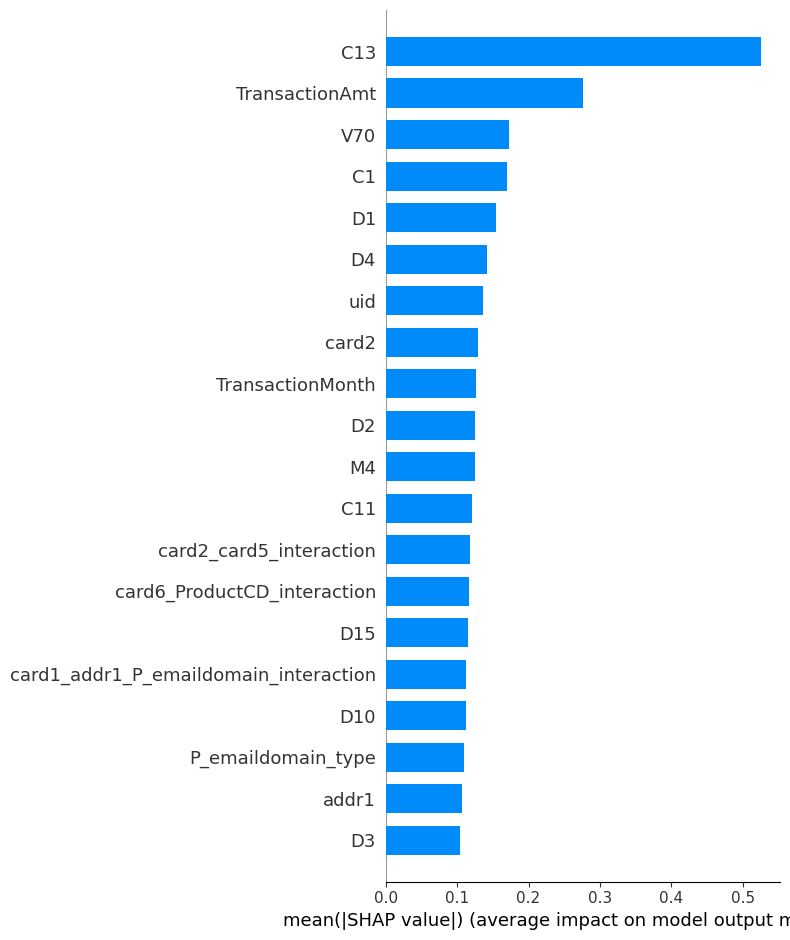

In [ ]:

# SHAP for LightGBM
explainer_lgbm = shap.TreeExplainer(best_model)
shap_values_lgbm = explainer_lgbm.shap_values(X_test)
shap.summary_plot(shap_values_lgbm, X_test, plot_type="bar", title="LightGBM Feature Importance")


# Validate Model against Test Dataset and Review Validation

# Test Data Test

What to double check test dataset to make sure its not screwed up.

Code performs a basic exploratory data analysis (EDA) on the dataset. It prints the dataset's structure and data types, provides descriptive statistics for numerical columns, and checks for missing values, unique values per column, and duplicate rows. 

If duplicates are found, they are optionally removed, and the updated dataset shape is displayed. 

Finally, the first few rows of the dataset are printed to give a quick preview of the data.

In [41]:
# Display basic information about the dataset
print("Dataset Information:")
test.info()

# Display descriptive statistics for numerical columns
print("\nDataset Description:")
print(test.describe())

# Check for missing values
print("\nMissing Values Count:")
print(test.isnull().sum())

# Check the number of unique values in each column
print("\nUnique Values per Column:")
print(test.nunique())

# Check for duplicate entries
duplicates = test.duplicated().sum()
print(f"\nNumber of Duplicate Rows: {duplicates}")

# Optional: Remove duplicate entries if needed
if duplicates > 0:
    test = test.drop_duplicates()
    print(f"Duplicates removed. New dataset shape: {df.shape}")

# Display the first few rows to explore the dataset
print("\nFirst Few Rows of the Dataset:")
test.head()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 506691 entries, 0 to 506690
Columns: 477 entries, TransactionID to composite_card_addr
dtypes: datetime64[ns](1), float16(306), float32(93), float64(17), int16(1), int32(6), int64(1), object(52)
memory usage: 766.4+ MB

Dataset Description:
       TransactionID                  TransactionDT  TransactionAmt  \
count   5.066910e+05                         506691   506691.000000   
mean    3.916894e+06  1970-11-08 16:32:17.228952168      134.725571   
min     3.663549e+06            1970-08-02 00:00:24        0.018000   
25%     3.790222e+06     1970-09-21 13:25:40.500000       40.000000   
50%     3.916894e+06            1970-11-11 20:50:58       67.949997   
75%     4.043566e+06     1970-12-29 19:56:00.500000      125.000000   
max     4.170239e+06            1971-01-31 23:59:05    10270.000000   
std     1.462692e+05                            NaN      245.779831   

               card1     card2     card3     card5   

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,uid,TransactionYear,TransactionMonth,TransactionDay,TransactionHour,TransactionWeekday,P_emaildomain_is_Google,P_emaildomain_is_Other,P_emaildomain_is_Apple,P_emaildomain_is_ProtonMail,P_emaildomain_is_Comcast,P_emaildomain_is_AOL,P_emaildomain_is_Verizon,P_emaildomain_is_Yahoo,P_emaildomain_is_Microsoft,P_emaildomain_type,R_emaildomain_is_Google,R_emaildomain_is_Other,R_emaildomain_is_Apple,R_emaildomain_is_ProtonMail,R_emaildomain_is_Comcast,R_emaildomain_is_AOL,R_emaildomain_is_Verizon,R_emaildomain_is_Yahoo,R_emaildomain_is_Microsoft,R_emaildomain_type,card1_card2_interaction,card1_card3_interaction,card1_card5_interaction,card1_card6_interaction,card2_card3_interaction,card2_card5_interaction,card2_card6_interaction,card3_card5_interaction,card3_card6_interaction,card5_card6_interaction,addr1_addr2_interaction,card1_ProductCD_interaction,card2_ProductCD_interaction,card3_ProductCD_interaction,card5_ProductCD_interaction,card6_ProductCD_interaction,card1_addr1_P_emaildomain_interaction,composite_card_addr
0,3663549,1970-08-02 00:00:24,31.950001,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,Google,Other,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

Code below looks to see if any columns are missing between train and test (outside for fraud and transactionid) converting the column names of both datasets into sets and then calculating the difference to find columns present in one dataset but not the other.

In [42]:
# Check to see if any columns are missing

import pandas as pd

def compare_columns(df1, df2):
    """
    Compare columns between two datasets and identify missing columns in each.
    
    Parameters:
        df1 (pd.DataFrame): The first dataset.
        df2 (pd.DataFrame): The second dataset.
    
    Returns:
        dict: A dictionary with missing columns in each dataset.
    """
    df1_columns = set(df1.columns)
    df2_columns = set(df2.columns)

    missing_in_df1 = df2_columns - df1_columns
    missing_in_df2 = df1_columns - df2_columns

    return {
        'missing_in_df1': list(missing_in_df1),
        'missing_in_df2': list(missing_in_df2)
    }

result = compare_columns(test, train)

# Output the results
print("Columns missing in df1:", result['missing_in_df1'])
print("Columns missing in df2:", result['missing_in_df2'])

Columns missing in df1: ['isFraud']
Columns missing in df2: ['TransactionID']


What to perform another check between test and train dataset.  

It checks whether the min, max, and mean values are consistent between the two datasets. Non-numerical columns are flagged as "N/A" for these checks. The function produces a summary DataFrame that details the results for each column, including data type matches and scale comparisons.

In [43]:
# Check to see if we standardsized/normalized the data

import pandas as pd
import numpy as np

def compare_columns_dtype_and_scale(df1, df2):
    """
    Compare columns between two datasets for data type and scale (range of values).
    
    Parameters:
        df1 (pd.DataFrame): The first dataset.
        df2 (pd.DataFrame): The second dataset.
    
    Returns:
        pd.DataFrame: A summary DataFrame showing differences in data type and scale.
    """
    comparison_results = []

    # Find common columns
    common_columns = set(df1.columns).intersection(set(df2.columns))

    for col in common_columns:
        col_result = {'Column': col}

        # Check data types
        dtype1 = df1[col].dtype
        dtype2 = df2[col].dtype
        col_result['DataType_Match'] = dtype1 == dtype2
        col_result['DataType_df1'] = str(dtype1)
        col_result['DataType_df2'] = str(dtype2)

        # Check scale
        if np.issubdtype(dtype1, np.number) and np.issubdtype(dtype2, np.number):
            scale1 = df1[col].describe()
            scale2 = df2[col].describe()

            col_result['Min_Match'] = scale1['min'] == scale2['min']
            col_result['Max_Match'] = scale1['max'] == scale2['max']
            col_result['Mean_Match'] = np.isclose(scale1['mean'], scale2['mean'], atol=1e-2)
        else:
            col_result['Min_Match'] = col_result['Max_Match'] = col_result['Mean_Match'] = 'N/A'

        comparison_results.append(col_result)

    return pd.DataFrame(comparison_results)

comparison_results = compare_columns_dtype_and_scale(test, train)
comparison_results.to_csv('comparison_results.csv', index=False)

# Visualize Performance

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load performance metrics from CSV
metrics_file = "C:/Users/gpbal/OneDrive/Desktop/performance_metrics.csv"
if not os.path.isfile(metrics_file):
    raise FileNotFoundError(f"The file {metrics_file} does not exist. Run the first script to generate it.")

metrics_df = pd.read_csv(metrics_file)

# Basic statistics and analysis
print("Basic Statistics:")
print(metrics_df.describe())




Basic Statistics:
       learning_rate  num_leaves   max_depth  feature_fraction  \
count     339.000000  339.000000  339.000000        339.000000   
mean        0.201984  111.525074   11.241888          0.815657   
std         0.088216   31.069141    3.283528          0.051923   
min         0.051330   31.000000    3.000000          0.702423   
25%         0.129594   93.000000    9.000000          0.777692   
50%         0.202677  119.000000   12.000000          0.819982   
75%         0.271644  136.500000   14.000000          0.858065   
max         0.367807  150.000000   15.000000          0.899893   

       bagging_fraction  bagging_freq  min_child_samples   lambda_l1  \
count        339.000000    339.000000         339.000000  339.000000   
mean           0.825919      3.253687          29.533923    0.550242   
std            0.050795      1.319161          10.726613    0.643679   
min            0.700463      1.000000          10.000000    0.050151   
25%            0.791533    

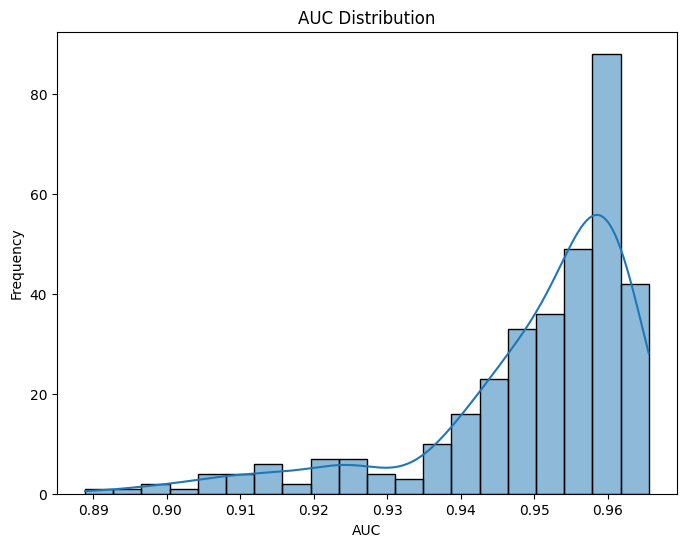

In [45]:
# Plot the AUC distribution
plt.figure(figsize=(8, 6))
sns.histplot(metrics_df['auc'], kde=True, bins=20)
plt.title("AUC Distribution")
plt.xlabel("AUC")
plt.ylabel("Frequency")
plt.show()


The model appears to perform reliably, but its generalization should be confirmed on an independent test set to ensure robustness and avoid overfitting concerns.

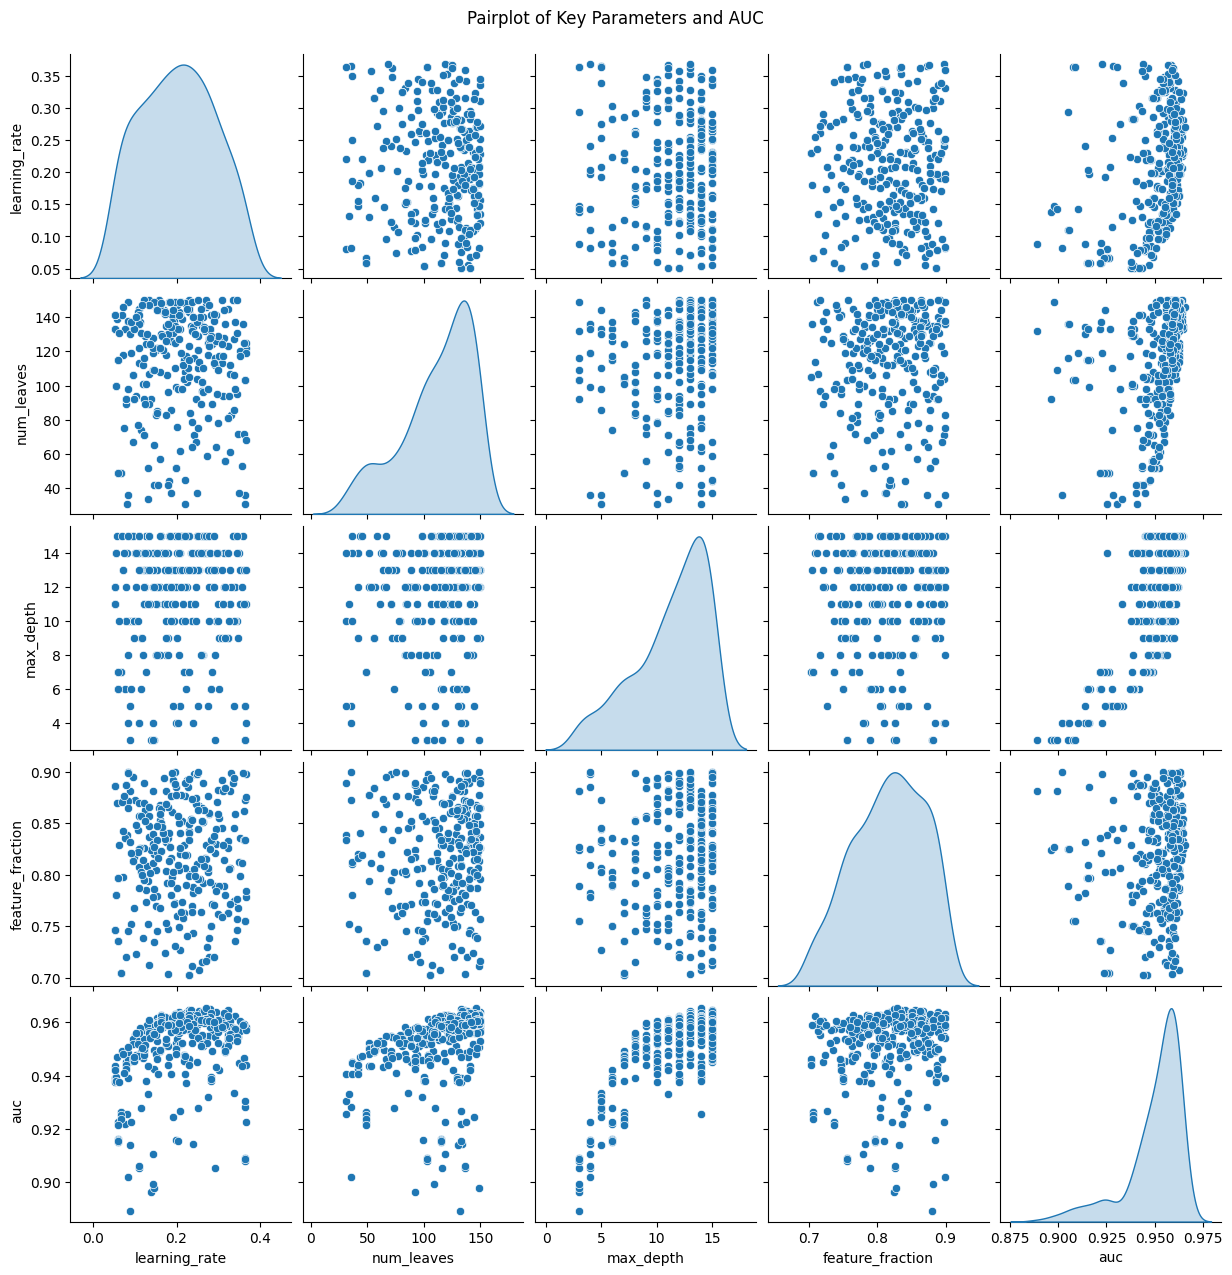

In [46]:

# Pairplot to visualize relationships between hyperparameters and AUC
sns.pairplot(metrics_df, vars=['learning_rate', 'num_leaves', 'max_depth', 'feature_fraction', 'auc'], kind="scatter", diag_kind="kde")
plt.suptitle("Pairplot of Key Parameters and AUC", y=1.02)
plt.show()



Plots seem  to reveals that while there is some variability, AUC values tend to cluster in specific parameter regions

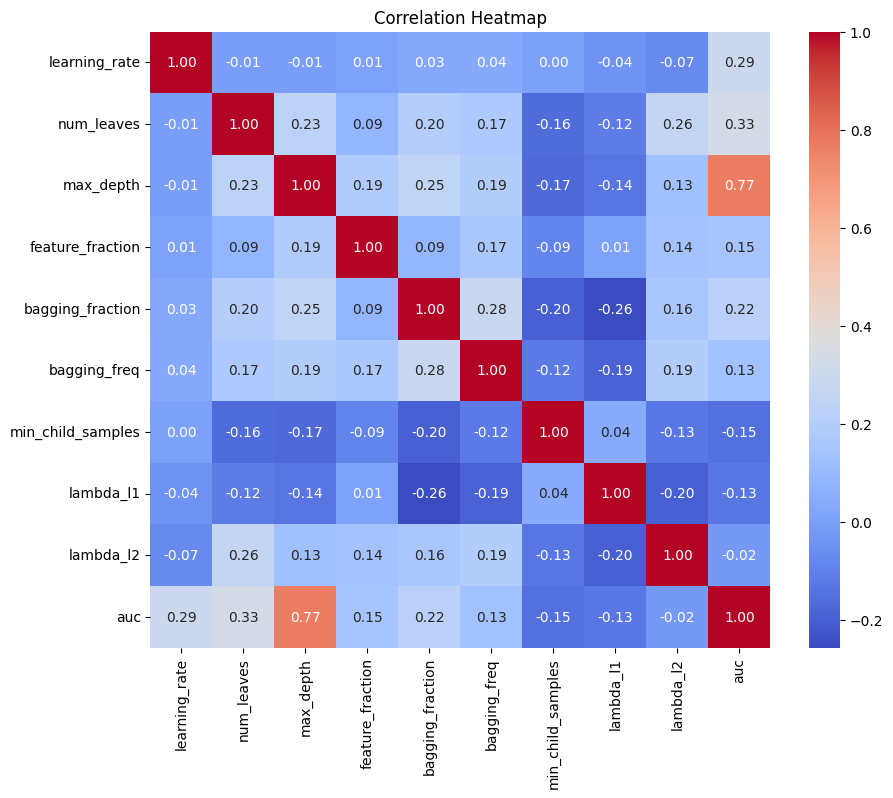

In [47]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation = metrics_df.corr()
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()



The heatmap reveals that tree depth (max_depth) and complexity (num_leaves) are the most influential factors driving AUC performance, while other parameters contribute more subtly.

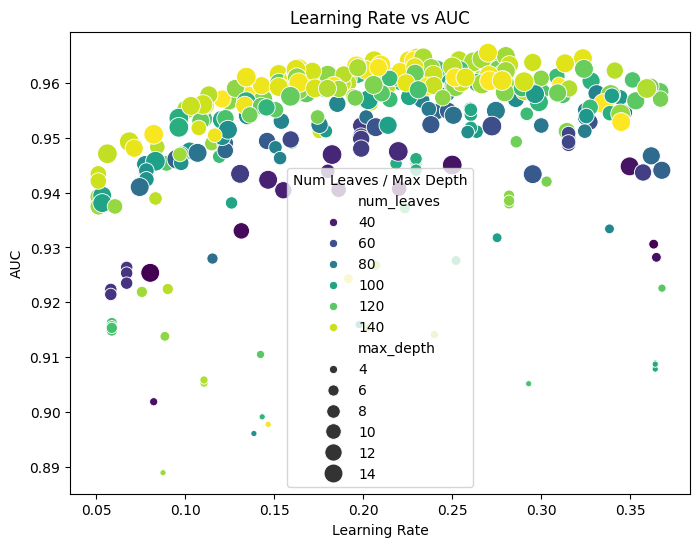

In [48]:
# Scatter plot: Learning rate vs AUC
plt.figure(figsize=(8, 6))
sns.scatterplot(data=metrics_df, x="learning_rate", y="auc", hue="num_leaves", palette="viridis", size="max_depth", sizes=(20, 200))
plt.title("Learning Rate vs AUC")
plt.xlabel("Learning Rate")
plt.ylabel("AUC")
plt.legend(title="Num Leaves / Max Depth")
plt.show()



The plot suggests that achieving optimal performance requires balancing learning rate, tree complexity (num_leaves), and depth (max_depth). A learning rate between 0.1 and 0.2, with moderately high num_leaves and max_depth, appears to yield the best results.

<Figure size 1200x600 with 0 Axes>

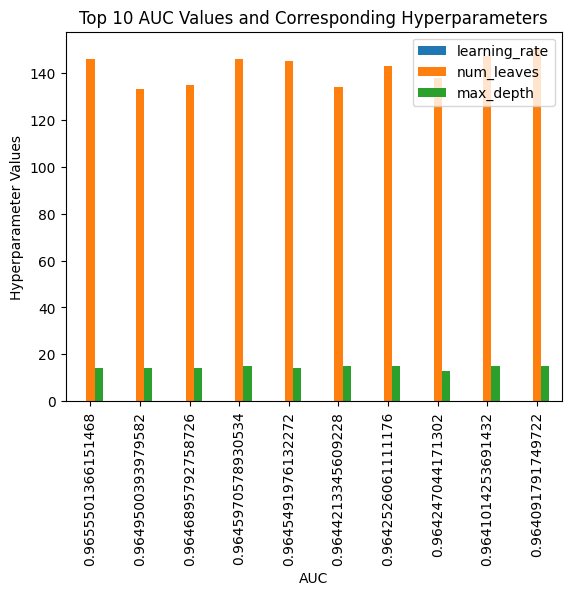

In [49]:
# Bar plot of top 10 AUC values with hyperparameters
top10 = metrics_df.nlargest(10, "auc")
plt.figure(figsize=(12, 6))
top10.plot.bar(x='auc', y=['learning_rate', 'num_leaves', 'max_depth'], legend=True)
plt.title("Top 10 AUC Values and Corresponding Hyperparameters")
plt.xlabel("AUC")
plt.ylabel("Hyperparameter Values")
plt.show()

The chart highlights that the best AUC scores are achieved using a combination of high num_leaves, moderate-to-deep max_depth, and low learning_rate. 

In [50]:
# Load Model
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,uid,TransactionYear,TransactionMonth,TransactionDay,TransactionHour,TransactionWeekday,P_emaildomain_is_Google,P_emaildomain_is_Other,P_emaildomain_is_Apple,P_emaildomain_is_ProtonMail,P_emaildomain_is_Comcast,P_emaildomain_is_AOL,P_emaildomain_is_Verizon,P_emaildomain_is_Yahoo,P_emaildomain_is_Microsoft,P_emaildomain_type,R_emaildomain_is_Google,R_emaildomain_is_Other,R_emaildomain_is_Apple,R_emaildomain_is_ProtonMail,R_emaildomain_is_Comcast,R_emaildomain_is_AOL,R_emaildomain_is_Verizon,R_emaildomain_is_Yahoo,R_emaildomain_is_Microsoft,R_emaildomain_type,card1_card2_interaction,card1_card3_interaction,card1_card5_interaction,card1_card6_interaction,card2_card3_interaction,card2_card5_interaction,card2_card6_interaction,card3_card5_interaction,card3_card6_interaction,card5_card6_interaction,addr1_addr2_interaction,card1_ProductCD_interaction,card2_ProductCD_interaction,card3_ProductCD_interaction,card5_ProductCD_interaction,card6_ProductCD_interaction,card1_addr1_P_emaildomain_interaction,composite_card_addr
0,3663549,1970-08-02 00:00:24,31.950001,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,Google,Other,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [55]:
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,uid,TransactionYear,TransactionMonth,TransactionDay,TransactionHour,TransactionWeekday,P_emaildomain_is_Google,P_emaildomain_is_Other,P_emaildomain_is_Apple,P_emaildomain_is_ProtonMail,P_emaildomain_is_Comcast,P_emaildomain_is_AOL,P_emaildomain_is_Verizon,P_emaildomain_is_Yahoo,P_emaildomain_is_Microsoft,P_emaildomain_type,R_emaildomain_is_Google,R_emaildomain_is_Other,R_emaildomain_is_Apple,R_emaildomain_is_ProtonMail,R_emaildomain_is_Comcast,R_emaildomain_is_AOL,R_emaildomain_is_Verizon,R_emaildomain_is_Yahoo,R_emaildomain_is_Microsoft,R_emaildomain_type,card1_card2_interaction,card1_card3_interaction,card1_card5_interaction,card1_card6_interaction,card2_card3_interaction,card2_card5_interaction,card2_card6_interaction,card3_card5_interaction,card3_card6_interaction,card5_card6_interaction,addr1_addr2_interaction,card1_ProductCD_interaction,card2_ProductCD_interaction,card3_ProductCD_interaction,card5_ProductCD_interaction,card6_ProductCD_interaction,card1_addr1_P_emaildomain_interaction,composite_card_addr
0,0,1970-01-02 00:00:00,68.5,W,13926,327.0,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,Other,Other,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

# Submission
Generates predictions using a pre-trained LightGBM model and prepares a submission file. It loads the test data, removes irrelevant columns, and predicts fraud probabilities (isFraud) for each transaction. The predictions are combined with their corresponding TransactionID into a DataFrame and saved as submission.csv, ready for evaluation or competition submission.

In [71]:
import pandas as pd

def align_columns(source_dataset, target_dataset):
    """
    """
    # Get source columns
    source_columns = source_dataset.columns

    # Add missing columns to target dataset
    for col in source_columns:
        if col not in target_dataset.columns:
            target_dataset[col] = 0  # Add missing column with default value

    # Remove extra columns from target dataset
    target_dataset = target_dataset[source_columns]

    # Save the aligned target dataset
    return target_dataset

# Example Usage


test_aligned = align_columns(X_train, test)


In [77]:
import pandas as pd

# Load the test data
X_test = test.drop(columns=["TransactionID"])  # Drop irrelevant columns
transaction_ids = test["TransactionID"]

"""
# Handle non-numeric columns
non_numeric_columns = X_test.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_columns)

# Drop or convert non-numeric columns
X_test = X_test.drop(columns=non_numeric_columns)  # Drop non-numeric columns
# Alternatively, convert datetime columns if needed
for col in X_test.select_dtypes(include=['datetime64']).columns:
    X_test[col] = X_test[col].view('int64')

# Ensure all columns are numeric
print("Updated dtypes:", X_test.dtypes)
"""
# Generate predictions using the preloaded model
y_pred = best_model.predict(X_test, num_iteration=best_model.best_iteration)

# Prepare submission dataframe
submission = pd.DataFrame({
    "TransactionID": transaction_ids,
    "isFraud": y_pred
})

# Save to CSV
submission.to_csv("submission.csv", index=False)
print("Submission file 'submission.csv' created successfully!")


Submission file 'submission.csv' created successfully!


# SUBMITTAL WAS PRIVATE SCORE OF 0.85 and Public Score was .88